# Простой генетический алгоритм

Для родственных моделей

Требуется подобрать такие параметры НРС, чтобы при заданных условиях (например, при требуемом расходе воды и подаче на требуемое расстояние), состав сил и средств был минимальный.

Критерии оптимизации (пример для расхода и расстояния):


$$
|\sum_{i=1}^{n}{Q_i}-Q_{треб.}|\longrightarrow min
$$

$$
|L_{НРС}-L_{треб.}|\longrightarrow min
$$



Мутации добавления отдельных элементов невозможны, поэтому нужно делать мутации блоками:

* ствол с рукавной линией
* магистральная рукавная линия

Нет, не так!

Типы мутаций:

* Разбить составной элемент, вставив другой элемент,
* Удалить элемент
* Изменить параметры элемента (количество рукавов, тип рукавов)
* Добавить рабочую рукавную линию

Основные категории элементов НРС:

* Насос ПА (Pump)
* напорная рукавная линия (Hose)
* всасывающая рукавная линия (InHose)
* разветвление (Splitter)
* водосборник (Joiner)
* ствол (Nozzle)


Также нужно добавить элемент который будет очищать мусор в модели.

## Обертка над NRS которая будет реализовывать более тонкие функции ГА

In [1]:
from nrs import NRS_Model, Element, NRS_Revision, NRS_Observer_E    # классы НРС
from nrs import NRS_Data                                            # Табличные данные НРС
from nrs import q_out_simple, q_out_nozzle                          # модели расчета параметров
import matplotlib.pyplot as plt                                     # библиотеки для отрисовки получаемых данных
import networkx as nx
import numpy as np
import random
import copy
import PIL
# from functools import reduce

import logging
logger = logging.getLogger('NRS')
# logger.setLevel(logging.DEBUG)
# logging.basicConfig(level=logging.DEBUG)

In [78]:
def print_NRS_graph(model, ax=None):
    '''
    Построение графа НРС
    '''
    # Цвета вершин
    colors={
        'GA_Element_Pump': 'gray',
        'GA_Element_Hose': 'blue',
        'GA_Element_InHose': 'black',
        'GA_Element_Splitter': 'green',
        'GA_Element_Joiner': 'green',
        'GA_Element_Nozzle': 'red',
    }

    try:
        G = nx.DiGraph()
        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())

        # Расчет расстояния до элементов
        for elmnt in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = elmnt.name, weight='L')
            nx.set_node_attributes(G, paths, 'L')   # Здесь нужна другая логика
            print(f'Расстояние до {elmnt.name} {max(paths.values())} м')    

        # Печать графа НРС с позициями
        pos={}
        pos_list=[]
        level=0
        for eo in model.elmnts_in:
            v = eo.name
            spl = dict(nx.single_source_shortest_path_length(G, v))
            for nd, p in spl.items():
                if not nd in pos.keys():
                    level_rize=level
                    cpos = (p,level_rize)
                    while cpos in pos_list:
                        level_rize+=1
                        cpos = (p,level_rize)
                    pos[nd]=cpos
                    pos_list.append(cpos)
            level+=1

        # nc = [nd[1]['L'] for nd in list(G.nodes(data=True))]
        # nx.draw(G, pos=pos, with_labels=True, node_color=nc)
        nc = [colors[e.id] for e in model.elmnts]
        if ax:
            nx.draw(G, pos=pos, with_labels=True, node_color=nc, ax=ax)
        else:
            nx.draw(G, pos=pos, with_labels=True, node_color=nc)

        return G
    except:
        print('Полный граф изобразить не возможно, будет отображен упрощенный')
        return print_NRS_graph_simple(model)

def print_NRS_graph_simple(model, ax=None):
    '''
    Построение графа НРС
    '''
    # Цвета вершин
    colors={
        'GA_Element_Pump': 'gray',
        'GA_Element_Hose': 'blue',
        'GA_Element_MHose': 'blue',
        'GA_Element_InHose': 'black',
        'GA_Element_Splitter': 'green',
        'GA_Element_Joiner': 'green',
        'GA_Element_Nozzle': 'red',
    }

    G = nx.DiGraph()
    # Узлы - на каждый элемент
    for elmnt in model.elmnts:
        G.add_node(elmnt.name, q=elmnt.q)
    # Ребра - на каждую связь
    for elmnt in model.elmnts:
        for elmnt_next in elmnt.elements_next:
            G.add_edge(elmnt.name, elmnt_next.name)

    nc = [colors[e.id] for e in model.elmnts]
    if ax:
        nx.draw(G, with_labels=True, node_color=nc, ax=ax)
    else:
        nx.draw(G, with_labels=True, node_color=nc)

    return G

def plot_nrs_compare(m1, m2):
    _, [ax1, ax2] = plt.subplots(1,2, figsize=(14,4))
    print_NRS_graph(m1, ax=ax1)
    print_NRS_graph(m2, ax=ax2)
    ax1.set_title('Было')
    ax2.set_title('Стало')
    plt.show()


def plot_nrs_with_icons(model, margin=15, size_reduce=0.004):
    '''
    Печать графа НРС с иконками
    '''
    icons = {
        "GA_Element_Pump": "icons/AC.png",
        "GA_Element_Splitter": "icons/Splitter.png",
        "GA_Element_Joiner": "icons/Joiner.png",
        "GA_Element_Hose": "icons/WHose.png",
        "GA_Element_MHose": "icons/MHose.png",
        "GA_Element_Nozzle": "icons/Nozzle.png",
    }
    images = {k: PIL.Image.open(fname) for k, fname in icons.items()}

    # Получаем граф
    G = Appraiser.get_G(model)

    # Печать графа НРС с позициями
    pos={}
    pos_list=[]
    level=0
    for eo in model.elmnts_in:
        v = eo.name
        spl = dict(nx.single_source_shortest_path_length(G, v))
        for nd, p in spl.items():
            if not nd in pos.keys():
                level_rize=level
                cpos = (p,level_rize)
                while cpos in pos_list:
                    level_rize+=1
                    cpos = (p,level_rize)
                pos[nd]=cpos
                pos_list.append(cpos)
        level+=1


    fig, ax = plt.subplots()

    nx.draw_networkx_edges(
        G,
        pos=pos,
        ax=ax,
        arrows=True,
        arrowstyle="-",
        min_source_margin=margin,
        min_target_margin=margin,
    )


    # Трансформация к координатам полотна
    tr_figure = ax.transData.transform
    tr_axes = fig.transFigure.inverted().transform

    # Определяем размер иконок
    icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * size_reduce
    icon_center = icon_size / 2.0

    # Добавляем иконки
    for n, d in G.nodes(data=True):
        elmnt = model.getElement(n)

        xf, yf = tr_figure(pos[n])
        xa, ya = tr_axes((xf, yf))
        a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
        a.imshow(images[elmnt.id])
        a.axis("off")

    plt.show()

#=========================================== Классы модели ГА ==============================================
class GA_model(NRS_Model):
    '''
    Класс модели НРС адаптированный для работы ГА
    '''
    def __init__(self, name):
        super().__init__(name)

    def appendElement(self, elmnt):
        
        # super().appendElement(elmnt)
        name_prefixes={
            'GA_Element_Pump': 'Н',
            'GA_Element_Hose': 'РРЛ',
            'GA_Element_MHose': 'МРЛ',
            'GA_Element_InHose': 'ВРЛ',
            'GA_Element_Splitter': 'Р', 
            'GA_Element_Joiner': 'ВС',
            'GA_Element_Nozzle': 'С',
        }
        if elmnt.name=='': elmnt.name=name_prefixes[elmnt.id]+str(self.counter)
            
        return super().appendElement(elmnt)
       
    def insertElement(self, elmnt:Element, elmntInsert:Element, pos=0):
        '''
        Вставка элемента в модель НРС.

        `elmnt`: Element
            Элемент относительно которого нужно вставить. Если не указан, вставляется элемент по правилам.

        `pos`: int
            Позиция: 0 - до элемента, 1 после.
        '''

        # До элемента
        if pos==0:
            logger.debug('Вставка до')
            if len(elmnt.elements_previous)>0:
                elmnt_in = random.choice(elmnt.elements_previous)
                elmnt.elements_previous.remove(elmnt_in)
                elmnt_in.elements_next.remove(elmnt)
                # print(type(elmntInsert))

                elmnt_in.append(elmntInsert).append(elmnt)
        # После элемента
        elif pos==1:
            logger.debug('Вставка после')
            if len(elmnt.elements_next)>0:
                elmnt_to = random.choice(elmnt.elements_next)
                elmnt.elements_next.remove(elmnt_to)
                elmnt_to.elements_previous.remove(elmnt)

                elmnt.append(elmntInsert).append(elmnt_to)            

        self.addElements([elmntInsert])
        
        return self

    def get_random_element_by_class(self, lst, clss):
        elmnt = None
        if element_class_test(lst, clss):
            while not isinstance(elmnt, clss):
                elmnt = random.choice(lst)
        else:
            elmnt = None
        return elmnt

    def getNewElement(self, elmnt:Element, pos=0):
        '''
        Правила добавления новых элементов
        '''
        if pos==0:
            e_class = allowed_prepend_classes[elmnt.id]
        elif pos==1:
            e_class = allowed_append_classes[elmnt.id]
        if isinstance(e_class, tuple):
            if len(e_class)>0:
                return random.choice(e_class)('', e_type=1)
            else:
                return None
        return e_class('', e_type=1)


    def crossing(self, pair_model, change_val=0.5):
    # def cross(mdl1, mdl2, change_val=0.5):
        cross_size = int(len(self.elmnts)*change_val)
        # скрещивание постоянных элементов
        # for elmnt1, elmnt2 in zip(mdl1.elmnts[cross_size:],mdl2.elmnts[cross_size:]):
        #     elmnt1.copy_props(elmnt2)
        # скрещивание случайных элементов
        elmnts_for_copy = random.sample(range(len(self.elmnts)), cross_size)
        for ei in elmnts_for_copy:
            elmnt1 = self.elmnts[ei]
            elmnt2 = pair_model.elmnts[ei]
            elmnt1.copy_props(elmnt2)
            # try:
            #     elmnt1 = self.elmnts[ei]
            # except IndexError as e:
            #     print(e)
            #     print(elmnt1.name, elmnt2.name, ei, elmnts_for_copy)
            # try:
            #     elmnt2 = pair_model.elmnts[ei]
            # except IndexError as e:
            #     print(e)
            #     print(elmnt1.name, elmnt2.name, ei, elmnts_for_copy)
            # try:
            #     elmnt1.copy_props(elmnt2)
            # except:
            #     print(elmnt1.name, elmnt2.name, ei, elmnts_for_copy)
        return self


    # def mutate(self, mutation_count=1, mutation_var=None, mutation_weights=[8,1,1,1,1]):
    def mutate(self, mutation_count=1, mutation_var=None, mutation_weights=[1,0,0,0,0]):
        '''
        Мутация элементов модели
        '''

        # Мутации
        for _ in range(mutation_count):
            if mutation_var:
                var = mutation_var
            else:
                # var = random.choice([0,1,2,3,4])
                var = random.choices([0,1,2,3,4], weights=mutation_weights)[0]

            # Микромутации
            if var==0:
                random.choice(self.elmnts).mutate()
            # Макромутации
            # удаление элемента
            if var==1:
                logger.debug('удаление элемента')
                self.delElement(random.choice(self.elmnts))
            # замена элемента
            if var==2:
                logger.debug('замена элемента')
                # pump <-> joiner <-> splitter
                # nozzle -> splitter
                elmnt_classes = [GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter, GA_Element_Nozzle]
                elmnt_class = random.choice(
                    elmnt_classes
                    )
                # elmnt = pop_random_element_by_class(self.elmnts, elmnt_class)
                elmnt = self.get_random_element_by_class(self.elmnts, elmnt_class)
                if elmnt:
                    logger.debug('Заменяется', elmnt.name)
                    if isinstance(elmnt, elmnt_classes[0]):
                        # Если насос:
                        if random.choice([True,False]):
                            # В разветвление:
                            new_elmnt = GA_Element_Splitter('', e_type=1, ri=1, ro=elmnt.ro)
                        else:
                            # В водосборник
                            new_elmnt = GA_Element_Joiner('', e_type=1, ri=elmnt.ri, ro=1)
                    elif isinstance(elmnt, elmnt_classes[1]):
                        # Если водосборник
                        # В насос
                        new_elmnt = GA_Element_Pump('', e_type=1, H_add=40)
                    elif isinstance(elmnt, elmnt_classes[2]):
                        # Если разветвление
                        if random.choice([True,False]):
                            # В насос
                            new_elmnt = GA_Element_Pump('', e_type=1, H_add=40)
                        else:
                            # В ствол (пока только А)
                            new_elmnt = GA_Element_Nozzle('', e_type=2, n_type='А', p=NRS_Revision.calc_p(7.4, 40), q_out = q_out_nozzle)
                    elif isinstance(elmnt, elmnt_classes[3]):
                        # Если ствол
                        # В разветвление
                        new_elmnt = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
                        new_hose = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2)
                        new_nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=NRS_Revision.calc_p(3.7, 40), q_out = q_out_nozzle)
                        new_elmnt.append(new_hose).append(new_nozzle)
                        self.addElements([new_hose, new_nozzle])

                    elmnts_next = elmnt.elements_next
                    elmnts_prev = elmnt.elements_previous
                    self.delElement(elmnt, fire_dead_elements=False)
                    new_elmnt.add_links(elmnts_prev, elmnts_next)
                    self.addElements([new_elmnt])
                    logger.debug(new_elmnt, type(new_elmnt), new_elmnt.name)
                        

            # вставка элемента
            if var==3:
                logger.debug('вставка элемента')
                elmnt = random.choice(self.elmnts)
                pos = random.choice([0,1])
                new_elmnt = self.getNewElement(elmnt, pos)
                if new_elmnt:
                    self.insertElement(elmnt, new_elmnt, pos)
            # добавление ветви из пресета
            if var==4:
                logger.debug('добавление ветви')
                # Определяем какие есть входы и выходы и исходя из этого добавляем ветвь нужного типа
                # elmnt = pop_random_element_by_class(self.elmnts, (GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter), lst_left=True)
                # elmnt = None
                # if element_class_test(self.elmnts, (GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter)):
                #     while not isinstance(elmnt, (GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter)):
                #         elmnt = random.choice(self.elmnts)
                # else:
                #     elmnt = None
                elmnt = self.get_random_element_by_class(self.elmnts, (GA_Element_Pump, GA_Element_Joiner, GA_Element_Splitter))
                if elmnt:
                    if elmnt.ro > len(elmnt.elements_next):
                        logger.debug('0', elmnt.name)
                        new_hose = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2)
                        new_nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=NRS_Revision.calc_p(3.7, 40), q_out = q_out_nozzle)
                        elmnt.append(new_hose).append(new_nozzle)
                        self.addElements([new_hose, new_nozzle])
                    elif elmnt.ri > len(elmnt.elements_previous):
                        logger.debug('1', elmnt.name)
                        new_pump = GA_Element_Pump('', e_type=0, H_add=40)
                        new_hose = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
                        new_pump.append(new_hose).append(elmnt)
                        self.addElements([new_pump, new_hose])
            
            # Если несколько компонентов;
            # соединение выход -> вход

            # соединение вход -> выход

        return self


    def check_pumps(self):
        '''
        Проверяет пожарные автомобили. 
        Для тех из них у которых есть только элементы на выход устанавливается e_type `0` (in).
        Для тех у кого имеются и те и те, ставится e_type `1` (inter).
        '''
        for elmnt in self.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                e_in = len(elmnt.elements_previous)
                e_out = len(elmnt.elements_next)
                if e_in==0 and e_out>0:
                    elmnt.type = 0
                if e_in>0 and e_out>0:
                    elmnt.type = 1
        return self
    
    def check_dead_elements(self):
        for elmnt in self.elmnts:
            self.fire_dead_elements_try(elmnt)
        return self



#======================================Модели элементов=======================================
class GA_Element_Pump(Element):
    '''
    Класс элемента `Пожарного автомобиля с насосом` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type, H_min=10, Q_min=0, H_max=100, Q_max=40, 
        q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=2, q_out=...):
        
        self.id = 'GA_Element_Pump'
        self.H_min = H_min
        self.H_max = H_max
        self.Q_min = Q_min
        self.Q_max = Q_max
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def set_H_add(self, H_add):
        if H_add>=self.H_min and H_add<=self.H_max:
            self.H_add = H_add
        elif H_add > self.H_max:
            # print("---", self.H_add, self.H_max)
            self.H_add = self.H_max
        elif H_add <= self.H_min:
            self.H_add = self.H_min


    def mutate(self):
        # mutation_case = random.choices([0,1,2,3],weights=[4,2,1,1])[0]
        mutation_case = random.choices([0,1,2,3],weights=[4,2,0,0])[0]
        # мутация напора
        if mutation_case==0:
            change_val = random.choice([-5,5])
            # print('H added')
            self.set_H_add(self.H_add+change_val)
        # Мутация производительности насоса
        if mutation_case==1:
            change_val = random.choice([40,60,70,100])
            self.Q_max = change_val
        # Мутация количества напорных патрубков
        if mutation_case==2:
            change_val = random.choice([2,4])
            self.set_ro(change_val)
        # Мутация всасывающих патрубков
        if mutation_case==3:
            change_val = random.choice([1,2,3,4])
            self.set_ri(change_val)

    def set_q(self, q):
        '''
        Устанавливает расход для текущего элемента,
        а так же далее запускает рекурсивный перерасчет расходов 
        для всех предыдущих относительно текущего элементов.\n
        Для каждого элемента происходит суммирование в том случае,
        если элемент является водосборником \n
        Если к элементу подключено несколько других элементов на вход
        Расход к ним разделяется поровну (в данной реализации).
        '''
        self.q+=q
        if self.q > self.Q_max:
            raise ValueError("Требуемый расход насоса слишком велик! Такое сочетание параметров неприемлемо!")

        for elmnt in self.elements_previous:
            elmnt.set_q(q/len(self.elements_previous))

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.set_H_add(elmnt.H_add)
        self.Q_max = elmnt.Q_max

        return self


class GA_Element_Hose(Element):
    '''
    Класс элемента `Рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, d='51', q=0, s=0.13, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=20, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_Hose'
        self.d=d
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        mutation_case = random.choice([0,1])
        # мутация количества
        if mutation_case==0:
            change_val = random.choice([i for i in range(-10,10)])
            if self.n+change_val>0:
                self.n = self.n+change_val
        # мутация диаметра
        if mutation_case==1:
            new_d=random.choice(['51', '66', '77'])
            self.d = new_d
            self.s = NRS_Data.ss[new_d]

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.n = elmnt.n
        self.d = elmnt.d
        self.s = elmnt.s

        return self


class GA_Element_MHose(Element):
    '''
    Класс элемента `Магистральной рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, d='77', q=0, s=0.015, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=20, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_MHose'
        self.d=d
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        mutation_case = random.choice([0,1])
        # мутация количества
        if mutation_case==0:
            change_val = random.choice([i for i in range(-10,10)])
            if self.n+change_val>0:
                self.n = self.n+change_val
        # мутация диаметра
        if mutation_case==1:
            new_d=random.choice(['77', '150'])
            self.d = new_d
            self.s = NRS_Data.ss[new_d]
    
    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.n = elmnt.n
        self.d = elmnt.d
        self.s = elmnt.s
        
        return self


class GA_Element_InHose(Element):
    '''
    Класс элемента `Всасывающей рукавной линии` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=4, ri=1, ro=1, q_out=...):
        self.id = 'GA_Element_InHose'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        pass

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        
        return self

class GA_Element_Splitter(Element):
    '''
    Класс элемента `Разветвление` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=3, q_out=...):
        self.id = 'GA_Element_Splitter'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # # мутация количества выходов
        # change_val = random.choice([2,3,4,5])
        # self.set_ro(change_val)
        pass

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.set_ro(elmnt.ro)
        
        return self

class GA_Element_Joiner(Element):
    '''
    Класс элемента `Водосборник` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=2, ro=1, q_out=...):
        self.id = 'GA_Element_Joiner'
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # мутация количества входов
        # change_val = random.choice([2,3,4,5])
        # self.set_ri(change_val)
        pass

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.set_ri(elmnt.ri)
        
        return self

class GA_Element_Nozzle(Element):
    '''
    Класс элемента `Ствол` адаптированный для работы ГА.
    '''
    def __init__(self, name, e_type=1, n_type='Б', q=0, s=0, H_in=0, h=0, H_add=0, z=0, p=1, n=1, l=0, ri=1, ro=0, q_out=...):
        '''
        `n_type` - тип ствола. `Б` - ручной ствол Б, `А` - ручной ствол А, `Л` - лафетный переносной, `ЛА` - лафетный автомобильный.
        '''
        self.id = 'GA_Element_Nozzle'
        self.n_type = n_type
        super().__init__(name, e_type, q, s, H_in, h, H_add, z, p, n, l, ri, ro, q_out)

    def mutate(self):
        # mutation_case = random.choice([0,1])
        # Мутация типа ствола
        change_val = random.choice(['А','Б','Л'])
        self.n_type = change_val
        if change_val=='А':
            self.p = NRS_Revision.calc_p(7.4, 40)
        if change_val=='Б':
            self.p = NRS_Revision.calc_p(3.7, 40)
        if change_val=='Л':
            self.p = NRS_Revision.calc_p(16, 40)

    def copy_props(self, elmnt):
        '''
        Копирует свойства переданного элемента
        '''
        self.p = elmnt.p
        self.n_type = elmnt.n_type
        
        return self

# Правила соединения элементов
# Классы которые могут быть присоединены после элемента
allowed_append_classes = {
        'GA_Element_Pump': (GA_Element_Hose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (GA_Element_Pump),
        'GA_Element_Splitter': (GA_Element_Hose), #,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Pump,GA_Element_Hose,GA_Element_Nozzle,GA_Element_Splitter),
        'GA_Element_Nozzle': (),
    }
# Классы которые могут быть присоединены перед элементом
allowed_prepend_classes = {
        'GA_Element_Pump': (GA_Element_Hose,GA_Element_Joiner,GA_Element_InHose),
        'GA_Element_Hose': (GA_Element_Pump,GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_InHose': (),
        'GA_Element_Splitter': (GA_Element_Hose,GA_Element_Joiner,GA_Element_Splitter),
        'GA_Element_Joiner': (GA_Element_Hose),
        'GA_Element_Nozzle': (GA_Element_Hose,GA_Element_Joiner),
    }


#=====================================Оценщик=====================================================================================================
class Appraiser(NRS_Revision):
    '''
    Класс-оценщик состояния модели
    '''
    
    @staticmethod
    def print_GA_NRS_model_elements_state(model:GA_model):
        print('='*80)
        print(model.name)
        print('='*80)
        
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Pump):
                print(f'Насос ({elmnt.name}); напор: {elmnt.H_add} м; производительность: {elmnt.q} л/с; напор макс.: {elmnt.H_max}')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, (GA_Element_Hose, GA_Element_MHose)):
                print(f'Рукавная линия ({elmnt.name}), длина: {elmnt.get_L()} м; диаметр: {elmnt.d} мм; сопротивление {elmnt.s}; расход: {elmnt.q} л/с; потеря напора: {elmnt.h} м')
        print('')
        for elmnt in model.elmnts:
            if isinstance(elmnt, GA_Element_Nozzle):
                print(f'Ствол ({elmnt.name}): "{elmnt.n_type}"; проводимость: {elmnt.p}; напор: {elmnt.H_in}, м; расход: {elmnt.q}, л/с')

    @staticmethod
    def get_G(model:GA_model):
        G = nx.DiGraph()

        # Узлы - на каждый элемент
        for elmnt in model.elmnts:
            G.add_node(elmnt.name, q=elmnt.q)
        # Ребра - на каждую связь
        for elmnt in model.elmnts:
            for elmnt_next in elmnt.elements_next:
                G.add_edge(elmnt.name, elmnt_next.name, L=elmnt.get_L())
        
        return G
    
    @staticmethod
    def get_Ls(G, model:GA_model):
        ''' 
        Расчет расстояний до элементов

        # Возвращает

        `p`: dict, `min_L`:float, `max_L`:float
            `p` - Словарь словарей, где ключ1 - имя насоса, ключ2 - имя ствола, значение - расстояние до него в метрах.
            `min_L` - Минимальное расстояние из имеющихся, м.
            `max_L` - Максимальное расстояние из имеющихся, м.
        '''
        max_L=0
        min_L=100000
        nozzles_names = [n.name for n in model.elmnts_out if n.type==2]
        p={}
        for e_pump in model.elmnts_in:
            paths = nx.shortest_path_length(G, source = e_pump.name, weight='L')
            dists = {k:v for k,v in paths.items() if k in nozzles_names}  
            p[e_pump.name] = dists
            cur_max_L = max(dists.values())
            cur_min_L = min(dists.values())
            if cur_max_L>max_L: max_L=cur_max_L
            if cur_min_L<min_L: min_L=cur_min_L
        return p, min_L, max_L
    
    @staticmethod
    def metrics(model:GA_model):
        '''
        Оценка модели
        '''
        m={'hoses':0,'nozzles':0}
        # Расчет длинн рукавных линий
        G = Appraiser.get_G(model)
        m['distances'], m['min_L'], m['max_L'] = Appraiser.get_Ls(G, model)        

        # Количество рукавов
        for elmnt in model.elmnts:
            if isinstance(elmnt, (GA_Element_Hose, GA_Element_MHose)):
                m['hoses']+=elmnt.n
                try:
                    m[elmnt.d]+=elmnt.n
                except:
                    m[elmnt.d]=elmnt.n
            if isinstance(elmnt, GA_Element_Nozzle):
                m['nozzles']+=elmnt.n
                try:
                    m[elmnt.n_type]+=1
                except:
                    m[elmnt.n_type]=1

        # напоры на насосах
        for elmnt in model.elmnts_in:
            m[f'{elmnt.name}:H_add'] = elmnt.H_add
        
        # Общий расход
        m['Q'] = model.summaryQ()

        return m
    
    @staticmethod
    def print_metrics(model:GA_model):
        for k, v in Appraiser.metrics(model).items():
            print(k,v, sep='\t')

    @staticmethod
    def evaluate(metrics: dict, aims: dict, aims_not_more=None, aims_not_less=None):
        '''
        Оценка модели

        `metrics`: dict
            Словарь метрик модели
        `aims`: dict
            Словарь целей оптимизации
        `aims_not_more`: dict
            Словарь целей оптимизации значения которых не могут быть выше некоторого значения.
            Например, если в модели не должно присутствовать более 10 рукавов диаметром 77мм.
        ''' 
        X = []
        Y = []
        for aim, aim_val in aims.items():
            if aim in metrics.keys():
                metric_val = metrics[aim]
                max_val = max(aim_val, metric_val)
                X.append(metric_val/max_val)
                Y.append(aim_val/max_val)
        if aims_not_more:
            # Цели "не более"
            for aim, aim_val in aims_not_more.items():
                if aim in metrics.keys():
                    metric_val = metrics[aim]
                    if metric_val>aim_val:
                        max_val = max(aim_val, metric_val)
                        X.append(metric_val/max_val)
                        Y.append(aim_val/max_val)
        if aims_not_less:
            # Цели "не менее"
            for aim, aim_val in aims_not_less.items():
                if aim in metrics.keys():
                    metric_val = metrics[aim]
                    if metric_val<aim_val:
                        max_val = max(aim_val, metric_val)
                        X.append(metric_val/max_val)
                        Y.append(aim_val/max_val)                        

        # Собственно оценка!
        z=[]
        for x,y in zip(X,Y):
            z.append(abs(y-x))

        return np.mean(z)





#======================================================Дополнительные инструменты=================================================================
def pop_random_element_by_class(lst, element_class=None, lst_left=False):
    '''
    Извлечение из списка элемента по классу

    `lst`
        Список элементов

    `element_class`
        Класс(ы) элементов

    `lst_left`
        Если True, то список сохраняется, иначе элемент будет удален.
    '''
    elmnt = None
    if element_class is None:
        elmnt = random.choice(lst)
    else:
        if element_class_test(lst, element_class):
            while not isinstance(elmnt, element_class):
                elmnt = random.choice(lst)
        else:
            return None
        
    if lst_left:
        return copy.deepcopy(elmnt)
    else:
        idx = lst.index(elmnt)
        return copy.deepcopy(lst.pop(idx))
    
def element_class_test(lst, element_class):
    for elmnt in lst:
        if isinstance(elmnt, element_class):
            return True
    return False

def drop_elements_links(lst):
    for elmnt in lst:
        elmnt.drop_links()


#==============================================Рекурсии=========================================================================
# Рекурсивное построение дерева
def append_new_element(elmnt, elmnts_examples, add_elmnts_p=0.5, lst_left=True):
    '''
    Рекурсивное построение дерева НРС
    '''
    global depth
    if depth<=0:
        print('Достигнут предел рекурсии')
        return
    depth-=1

    # print(len(elements_sack))

    # ограничение списка приемлемых классов
    allowed_element_classes = allowed_append_classes[elmnt.id]
    # print(elmnt.id, 'Можно:')
    # print(allowed_element_classes)

    if elmnt.ro>0:
        # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
        # print(len(elmnts_examples))
        random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
        if random_elmnt is None: return
        # print(len(elmnts_examples))
        if elmnt.append(random_elmnt):
            append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)

    for _ in range(elmnt.ro-1):
        logger.debug(f'Элемент {type(elmnt)}, выходов {elmnt.ro}')
        rnd = random.random()
        if rnd<=add_elmnts_p:
            # random_elmnt = copy.deepcopy(pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left))
            # print(len(elmnts_examples))
            random_elmnt = pop_random_element_by_class(elmnts_examples, element_class=allowed_element_classes, lst_left=lst_left)
            if random_elmnt is None: return
            # print(len(elmnts_examples))
            if elmnt.append(random_elmnt):
                append_new_element(random_elmnt, elmnts_examples, lst_left=lst_left)


def fire_dead_elements_try(model:NRS_Model, elmnt: Element):
    '''
    Рекурсивная попытка удалить мертвые элементы из модели
    '''
    print(elmnt.name)
    if elmnt.type==0 and len(elmnt.elements_next)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==1 and (len(elmnt.elements_next)==0 or len(elmnt.elements_previous)==0):
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        for ep in elmnt.elements_previous:
            model = fire_dead_elements_try(model, ep)
        model.delElement(elmnt)
    elif elmnt.type==2 and len(elmnt.elements_previous)==0:
        elmnt.drop_links(linked_elements=True, current_element=False)
        for en in elmnt.elements_next:
            model = fire_dead_elements_try(model, en)
        model.delElement(elmnt)
    return model


#==================================================== Класс ветви =================================================
class Branch(NRS_Model):
    '''
    Класс ветви модели. Может быть трех типов:

    `FULL=0` Имеет и источник и потребитель (насос и ствол).
        Например простая модель НРС АЦ->Рукав->Ствол.

    `INWARD=1` Имеет только вход. Выход открыт (оканчивается рукавом)
        Например, Рукавные линии начинающиеся от насосов. Могут подключаться на вход к водосборникам или насосам.

    `OUTWARD=2` Имеет только выход. Вход открыт (начинается с рукава). 
        Например, рабочие рукавные линии. Могут подключаться на выход к разветвлениям или насосам.

    `-1` Не распознана.
    '''

    def __init__(self, name=''):
        self.elmnts_names = []
        self._branch_type = -1
        super().__init__(name)

    def getBranch(self, model:NRS_Model, elmnt=None):
        '''
        Из `model` выделяется ветвь в которую входит элемент `elmnt`. 
        Если `elmnt` не передан, он выбирается случайно.
        '''
        # Если элемент не передан, выбираем его случайным образом
        if elmnt is None:
            elmnt = random.choice(model.elmnts)
        # Если передано имя элемента, получаем его по имени, иначе предполагается использование объекта
        if isinstance(elmnt, str):
            elmnt = model.getElement(elmnt)
        if not isinstance(elmnt, Element):
            raise TypeError('Должен быть элемент НРС!')

        self._elementAdd(elmnt)

        return self
    
        
    def _elementAdd(self, elmnt:Element):
        '''
        Рекурсивное добавление элементов в модель
            Вход:
                elmnt=Element: элемент который следует добавить модель. 
                Далее _elementAdd будет вызвана для всех подключенных к нему элементов
        '''
        if not elmnt in self.elmnts:
            self.addElements([elmnt])
            for linked in elmnt.elements_next:
                if isinstance(linked, (GA_Element_Hose, GA_Element_MHose, GA_Element_Nozzle)):
                    self._elementAdd(linked)
            for linked in elmnt.elements_previous:
                if isinstance(linked, (GA_Element_Hose, GA_Element_MHose, GA_Element_Pump)):
                    self._elementAdd(linked)

    def interpretate(self):

        super().interpretate()
        # Определение типа ветви
        if len(self.elmnts_in)>0 and len(self.elmnts_out)>0:
            self._branch_type = 0
        elif len(self.elmnts_in)>0 and len(self.elmnts_out)==0:
            self._branch_type = 1
        elif  len(self.elmnts_in)==0 and len(self.elmnts_out)>0:
            self._branch_type = 2
        # Определение входных элементов
        for elmnt in self.elmnts:
            if len(self.elmnts_in) + len(self.elmnts_out) ==1:
                self.plugin = elmnt

        return self
    
    @property
    def branch_type(self):
        t = {0:'ПОЛНАЯ', 1:'ВХОДЯЩАЯ', 2:'ИСХОДЯЩАЯ', -1:'НЕ РАСПОЗНАНО'}
        return t[self._branch_type]
    
    def deep_copy(self):
        '''
        Делает глубокую копию элементов. Требуется для удаления связей с исходной моделью.
        '''
        tmp_col = []
        for elmnt in self.elmnts:
            # print(tmp_col, elmnt.name)
            tmp_col.append(copy.deepcopy(elmnt).drop_links())
        for elmnt in self.elmnts:
            # print(tmp_col, elmnt.name)
            elmnt_copy = NRS_Revision.get_element_by_name(tmp_col, elmnt.name, False)
            for linked in elmnt.elements_next:
                linked_copy = NRS_Revision.get_element_by_name(tmp_col, linked.name, False)
                if linked_copy:
                    elmnt_copy.append(linked_copy)
            for linked in elmnt.elements_previous:
                linked_copy = NRS_Revision.get_element_by_name(tmp_col, linked.name, False)
                if linked_copy:
                    linked_copy.append(elmnt_copy)

        self.elmnts = tmp_col
        
        return self
    
    def drop_names(self):
        '''
        Обезличивает (удаляет имена) элементов ветви.
        Требуется для корректной передачи в другие модели, где элементы будут переименованы в соответствии с моделью.
        '''
        for elmnt in self.elmnts:
            elmnt.name = ''
        return self
    
    def plug(self, elmnt):
        '''
        Прививает ветвь к указанному элементу.

        Если ветвь входящая, то прививается на вход (если возможно). 
        Если исходящая - на выход (если возможно)
        Если полная или нераспознанная, ничего не происходит
        '''
        # ВХОДЯЩАЯ
        if self._branch_type==1:
            self.plugin.append(elmnt)
        # ИСХОДЯЩАЯ
        if self._branch_type==2:
            elmnt.append(self.plugin)

        return self

# Пресеты

In [3]:
class Presets():

    @staticmethod
    def single_line():
        '''
        Простая НРС с одной РРЛ и одним стволом

            |=|>-------------|->
        '''
        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hose = GA_Element_Hose('', e_type=1, s=NRS_Data.ss["51"], n=2)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)

        pump.append(hose).append(nozzle)

        model = GA_model('Простая НРС с одной РРЛ и одним стволом')
        model.addElements([pump,hose,nozzle])
        return model.check_pumps().interpretate()
    
    @staticmethod
    def single_splitter(nozzles_count=3):
        '''
        Сложная НРС с одним разветвлением и nozzles_count рабочих линий

                             ------|->
            |=|>------{------|->
                             ------|->
            
        '''
        if not nozzles_count in [1,2,3]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 3!")

        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        model = GA_model('Сложная НРС с одним разветвлением и nozzles_count рабочих линий')

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hoseM = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        pump.append(hoseM).append(spliiter)

        model.addElements([pump,hoseM,spliiter])

        for _ in range(nozzles_count):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def two_splitter(nozzles_count1=2, nozzles_count2=3):
        '''
        Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка

                             ------|->          ------|->
            |=|>------{------------------{------|->
                             ------|->          ------|->
            
        '''
        if not nozzles_count1 in [1,2]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 2!")
        if not nozzles_count2 in [1,2,3]:
            raise ValueError("Количество стволов не может быть меньше 1 и больше 3!")

        p_nozzleB = NRS_Revision.calc_p(3.7, 40)

        model = GA_model('Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка')

        pump = GA_Element_Pump('', e_type=1, H_add=40)
        hoseM1 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter1 = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        hoseM2 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        spliiter2 = GA_Element_Splitter('', e_type=1, ri=1, ro=3)
        pump.append(hoseM1).append(spliiter1).append(hoseM2).append(spliiter2)

        model.addElements([pump,hoseM1,spliiter1,hoseM2,spliiter2])

        for _ in range(nozzles_count1):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter1.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])
        for _ in range(nozzles_count2):
            hoseW = GA_Element_Hose('', e_type=1, d='51', s=NRS_Data.ss["51"], n=2)
            nozzle = GA_Element_Nozzle('', e_type=2, n_type='Б', p=p_nozzleB, q_out = q_out_nozzle)
            spliiter2.append(hoseW).append(nozzle)
            model.addElements([hoseW,nozzle])
        
        return model.check_pumps().interpretate()

    @staticmethod
    def single_joiner(nozzle_q=20, nozzle_workpress=60):
        '''
        Сложная НРС с одним водосборником и лафетным стволом

            |=|>------
                             }------|-,->
            |=|>------
            
        '''

        p_nozzleL = NRS_Revision.calc_p(nozzle_q, nozzle_workpress)

        model = GA_model('Сложная НРС с одним водосборником и лафетным стволом')

        pump1 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM1 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        pump2 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM2 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        joiner = GA_Element_Joiner('', e_type=1, ri=2, ro=1)
        hoseW1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Л', p=p_nozzleL, q_out = q_out_nozzle)

        pump1.append(hoseM1).append(joiner)
        pump2.append(hoseM2).append(joiner)
        joiner.append(hoseW1).append(nozzle)

        model.addElements([pump1,hoseM1,pump2,hoseM2,joiner,hoseW1,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def single_pump_to_joiner_by2(nozzle_q=20, nozzle_workpress=60):
        '''
        Простая НРС с одним, насосом, водосборником и лафетным стволом

                    ------
            |=|>...............}------|-,->
                    ------
            
        '''

        p_nozzleL = NRS_Revision.calc_p(nozzle_q, nozzle_workpress)

        model = GA_model('Сложная НРС с одним водосборником и лафетным стволом')

        pump1 = GA_Element_Pump('', e_type=1, H_add=80)
        hoseM1 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        hoseM2 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=2)
        joiner = GA_Element_Joiner('', e_type=1, ri=2, ro=1)
        hoseW = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss["77"], n=1)
        nozzle = GA_Element_Nozzle('', e_type=2, n_type='Л', p=p_nozzleL, q_out = q_out_nozzle)

        pump1.append(hoseM1).append(joiner).append(hoseW).append(nozzle)
        pump1.append(hoseM2).append(joiner)

        model.addElements([pump1,hoseM1,hoseM2,joiner,hoseW,nozzle])

        return model.check_pumps().interpretate()
    
    @staticmethod
    def n_components(n=2):
        '''
        Простая НРС из n компонентов в виде простых НРС

            n * |=|>-------------|->
            
        '''
        model = GA_model(f'Простая НРС из {n} компонентов в виде простых НРС')

        for _ in range(n):
            for e in Presets.single_line().elmnts:
                e.name=''
                model.addElements([e])

        return model.check_pumps().interpretate()

# Применение ГА

## Реализация алгоритма

In [4]:
def get_sample_model(model_preset, mutation_count=20):
    return model_preset().mutate(mutation_count)

# функция по которой будем сортировать модели
def sort_key(m):
  return m.err

# Собственно ГА
def genetic_algorithm(model_preset, aims, aims_not_more=None, aims_not_less=None,
                        pop_size = 200, best_bots_size = 25, epochs=100, mutation_count=1,
                        accuracy=0.05, target=0.001):
    ''' Генетический алгоритм

    `pop_size` = 200  
        Размер популяции

    `best_bots_size` = 25   
        Количество лучших в популяции

    `epochs`=100              
        Количество эпох

    `mutation_count` = 1   
        Количество мутаций модели в эпоху

    `aims`: dict
        Словарь строгих целей оптимизации

    `aims_not_more`: dict
        Словарь целей оптимизации значения которых не могут быть выше некоторого значения.
        Например, если в модели не должно присутствовать более 10 рукавов диаметром 77мм.

    `aims_not_less`: dict
        Словарь целей оптимизации значения которых не могут быть ниже некоторого значения.
        Например, если в модели должно быть использован не менее 10 рукавов диаметром 51мм.

    `accuracy`: 0.05
        Точность расчета модели.

    `target`: 0.001
        Целевая точность алгоритма.
    '''
    
    # Генерируем стартовую популяцию
    population = [get_sample_model(model_preset=model_preset, mutation_count=mutation_count) for _ in range(pop_size)]
    print("Размер популяции: ", len(population), "особей")

    # !!! Запускаем генезис:
    accs=[]
    metrics = []
    for epoch in range(epochs):
        # Обучаем всех моделей в популяции
        i=1
        for m in population:
            try:
                m.calc(accuracy=accuracy)
                m.metric = Appraiser.metrics(m)
                m.err = Appraiser.evaluate(m.metric, aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less)
            except:
                # Если модель нежизнеспособна, ошибка максимальна
                m.err=1
            i+=1

        # Получаем best_bots_size лучших ботов
        bots_sorted = sorted(population, key=sort_key)[:best_bots_size]
        print(epoch, '>>', bots_sorted[0].summaryQ(),  "л/с : ", bots_sorted[0].err)  
        accs.append(bots_sorted[0].err)
        metrics.append(bots_sorted[0].metric)
        
        # Если достигнут целевой показатель точности, выходим из цикла
        if bots_sorted[0].err <= target:
            break

        # От лучших моделей создаем новую популяцию
        population = []
        for i in range(pop_size - best_bots_size):
            bot_father = copy.deepcopy(random.choice(bots_sorted))  # bots_sorted[np.random.randint(0,len(bots_sorted)-1)]
            bot_mother = random.choice(bots_sorted)  # bots_sorted[np.random.randint(0,len(bots_sorted)-1)]
            if bot_father!=bot_mother:
                bot_father.crossing(bot_mother).mutate(mutation_count=mutation_count, mutation_weights=[1,0,0,0,0])
                population.append(bot_father)

        # Дополняем популяцию лучшими представителями)
        for b in bots_sorted:
            population.append(b)

        # # График
        # fig, ax = plt.subplots(1,1)
        # ax.plot(accs)

        # plt.title('Процесс оптимизаци модели')
        # plt.xlabel('эпоха', fontsize=14)
        # plt.ylabel('ошибка', fontsize=14)

        # plt.savefig(f'graphs/{epoch}.png')
        # plt.show()


    # Печать итоговых значений
    for m in population:
        try:
            m.calc(accuracy=accuracy)
            m.err = Appraiser.evaluate(Appraiser.metrics(m), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less)
        except:
            # Если модель нежизнеспособна, ошибка максимальна
            m.err=1
    best_bot = sorted(population, key=sort_key)[0]

    return best_bot, accs, metrics


## Расчет для модели НРС из пресета

In [17]:
# Цели оптимизации:
aims = {'38дв':0, '51нп':0, '66нп':0,'110': 0, '150': 0, '200': 0, '225': 0, '250': 0, '300': 0, 'hoses':0, 'max_L': 300}
aims_not_more = {'51':20, '66':20, '77':16, '89':10} 
aims_not_less = {'min_L': 260, 'Q':10}

# Запуск ГА:
work_model, accs, _ = genetic_algorithm(model_preset=Presets.single_splitter,
                               aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less,
                               pop_size=300,
                               best_bots_size = 50,
                               mutation_count=5,
                               epochs=100,
                               target = 0.001
                               )

Размер популяции:  300 особей
0 >> 8.90128836749012 л/с :  0.34669856004351624
1 >> 8.702062936442804 л/с :  0.29435318849369185
2 >> 9.909913321280614 л/с :  0.27148293619875385
3 >> 9.918340480290933 л/с :  0.2712722572234959
4 >> 9.295099558433236 л/с :  0.2647767418630095
5 >> 9.304714404491953 л/с :  0.26458444494183514
6 >> 9.308756822623653 л/с :  0.26450359657920114
7 >> 9.603992457238189 л/с :  0.23506947212220455
8 >> 9.603823996978821 л/с :  0.23507284132739187
9 >> 9.603765034195844 л/с :  0.23507402058305144
10 >> 9.603749817940827 л/с :  0.23507432490815178
11 >> 9.603745906599883 л/с :  0.23507440313497066
12 >> 9.680844976420907 л/с :  0.23353242173855016
13 >> 9.674002313575953 л/с :  0.23366927499544926
14 >> 9.67241257127342 л/с :  0.23370106984149994
15 >> 9.672043352691084 л/с :  0.23370845421314662
16 >> 9.671957608125968 л/с :  0.23371016910444897
17 >> 9.67193769580839 л/с :  0.2337105673508005
18 >> 9.671933071623432 л/с :  0.2337106598344997
19 >> 9.6819283785

Сложная НРС с одним разветвлением и nozzles_count рабочих линий
Насос (Н0); напор: 45 м; производительность: 9.9091566910942 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 160 м; диаметр: 77 мм; сопротивление 0.015; расход: 9.9091566910942 л/с; потеря напора: 11.782966359438833 м
Рукавная линия (НРЛ3), длина: 140 м; диаметр: 66 мм; сопротивление 0.034; расход: 3.242259897833297 л/с; потеря напора: 2.5019153203333193 м
Рукавная линия (НРЛ5), длина: 100 м; диаметр: 77 мм; сопротивление 0.015; расход: 3.329266721751662 л/с; потеря напора: 0.8313012678422295 м
Рукавная линия (НРЛ7), длина: 80 м; диаметр: 77 мм; сопротивление 0.015; расход: 3.3376300715092415 л/с; потеря напора: 0.668386469654567 м

Ствол (С4): "Б"; проводимость: 0.5850213671311502; напор: 30.71511832022785, м; расход: 3.242259897833297, л/с
Ствол (С6): "Б"; проводимость: 0.5850213671311502; напор: 32.38573237271894, м; расход: 3.329266721751662, л/с
Ствол (С8): "Б"; проводимость: 0.5850213671311502; напор: 32.5486471

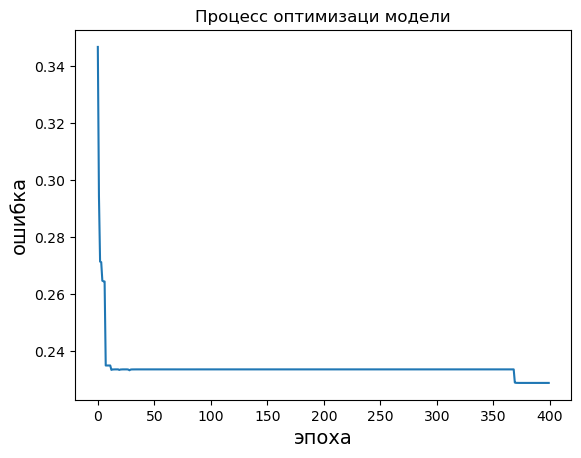

In [18]:
# Печать итогов
Appraiser.print_GA_NRS_model_elements_state(work_model)

print("Точность модели:", 
        Appraiser.evaluate(Appraiser.metrics(work_model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('')
Appraiser.print_metrics(work_model)

fig, ax = plt.subplots(1,1)
ax.plot(accs)

plt.title('Процесс оптимизаци модели')
plt.xlabel('эпоха', fontsize=14)
plt.ylabel('ошибка', fontsize=14)

plt.show()

## Расчет для произвольной модели

Расстояние до Н1 60 м


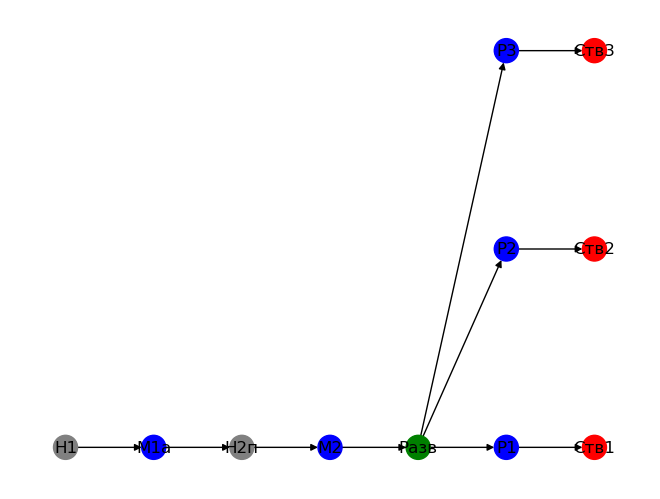

In [19]:
# Функция для построения произвольной модели
def build_sample_model():
    # Структура модели
    pump1 = GA_Element_Pump('Н1', e_type=0)
    hoseM1 = GA_Element_MHose('М1а', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseM2 = GA_Element_MHose('М1б', e_type=1, d='77', s=NRS_Data.ss['77'])
    pump2 = GA_Element_Pump('Н2п', e_type=1)
    hoseM3 = GA_Element_MHose('М2', e_type=1, d='77', s=NRS_Data.ss['77'])
    splitter = GA_Element_Splitter('Разв', e_type=1)
    hoseW1 = GA_Element_Hose('Р1', e_type=1, d='51', s=NRS_Data.ss['51'])
    hoseW2 = GA_Element_Hose('Р2', e_type=1, d='51', s=NRS_Data.ss['51'])
    hoseW3 = GA_Element_Hose('Р3', e_type=1, d='51', s=NRS_Data.ss['51'])
    nozzle1 = GA_Element_Nozzle('Ств1', e_type=2, n_type='Б', p=NRS_Revision.calc_p(3.7, 40), q_out=q_out_nozzle)
    nozzle2 = GA_Element_Nozzle('Ств2', e_type=2, n_type='Б', p=NRS_Revision.calc_p(3.7, 40), q_out=q_out_nozzle)
    nozzle3 = GA_Element_Nozzle('Ств3', e_type=2, n_type='Б', p=NRS_Revision.calc_p(3.7, 40), q_out=q_out_nozzle)

    pump1.append(hoseM1).append(pump2)
    # pump1.append(hoseM2).append(pump2)
    pump2.append(hoseM3).append(splitter)
    splitter.append(hoseW1).append(nozzle1)
    splitter.append(hoseW2).append(nozzle2)
    splitter.append(hoseW3).append(nozzle3)

    model = GA_model('Модель 1P-2H-1P-1H-1S-3N')
    # model.addElements([pump1,hoseM1,hoseM2,pump2,hoseM3,splitter,hoseW1,hoseW2,hoseW3,nozzle1,nozzle2,nozzle3])
    model.addElements([pump1,hoseM1,pump2,hoseM3,splitter,hoseW1,hoseW2,hoseW3,nozzle1,nozzle2,nozzle3])
    return model.check_pumps().interpretate()

model = build_sample_model()
print_NRS_graph(model)

In [21]:
# Цели оптимизации:
aims = {'38дв':0, '51нп':0, '66нп':0, '89':0, '110': 0, '150': 0, '200': 0, '225': 0, '250': 0, '300': 0, 'hoses':0, 'max_L': 1200}
# aims_not_more = {'150': 100, '51':20, '77':16, '89':10} 
aims_not_more = {'51':20, '66':20, '77':16} 
aims_not_less = {'min_L': 1000, 'Q':20}

# Запуск ГА:
work_model, accs, _ = genetic_algorithm(model_preset=build_sample_model,
                               aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less,
                               pop_size=400,
                               best_bots_size = 50,
                               mutation_count=5,
                               epochs=100,
                               target = 0.01
                               )

Размер популяции:  400 особей
0 >> 5.126992821225205 л/с :  0.6358281110034343
1 >> 5.119566898905564 л/с :  0.6359023702266307
2 >> 6.368625742375569 л/с :  0.6027451151252639
3 >> 7.0928498484534686 л/с :  0.5928362073978183
4 >> 18.710519939650545 л/с :  0.4682281339368279
5 >> 18.71671443247827 л/с :  0.46816618900855067
6 >> 15.826926930230247 л/с :  0.4080884609372774
7 >> 15.822268149041408 л/с :  0.408127284113851
8 >> 15.948174781969223 л/с :  0.40130956122401934
9 >> 15.586251472835084 л/с :  0.39658515929500177
10 >> 17.16602994083433 л/с :  0.38508700539500795
11 >> 15.018906748917772 л/с :  0.3560600452154286
12 >> 15.00890491542896 л/с :  0.3561314868832058
13 >> 15.006012409733891 л/с :  0.35615214763817055
14 >> 16.427468047601536 л/с :  0.3459988930819731
15 >> 16.434191873108013 л/с :  0.34595086575692685
16 >> 18.74203850127683 л/с :  0.3324268158272143
17 >> 18.73441582838697 л/с :  0.33248126349071333
18 >> 18.731567603043363 л/с :  0.33250160795745337
19 >> 18.730

Модель 1P-2H-1P-1H-1S-3N
Насос (Н1); напор: 20 м; производительность: 19.61460492180882 л/с; напор макс.: 100
Насос (Н2п); напор: 15 м; производительность: 19.61460492180882 л/с; напор макс.: 100

Рукавная линия (М1а), длина: 520 м; диаметр: 150 мм; сопротивление 0.00046; расход: 19.61460492180882 л/с; потеря напора: 4.601403405814153 м
Рукавная линия (М2), длина: 400 м; диаметр: 150 мм; сопротивление 0.00046; расход: 19.61460492180882 л/с; потеря напора: 3.5395410813955026 м
Рукавная линия (Р1), длина: 60 м; диаметр: 77 мм; сопротивление 0.015; расход: 11.552538483171993 л/с; потеря напора: 6.005751543232561 м
Рукавная линия (Р2), длина: 280 м; диаметр: 77 мм; сопротивление 0.015; расход: 5.344107186866623 л/с; потеря напора: 5.99749114119101 м
Рукавная линия (Р3), длина: 420 м; диаметр: 66 мм; сопротивление 0.034; расход: 2.7179592517702043 л/с; потеря напора: 5.274533980918179 м

Ствол (Ств1): "Л"; проводимость: 2.5298221281347035; напор: 20.853303969557786, м; расход: 11.5525384831

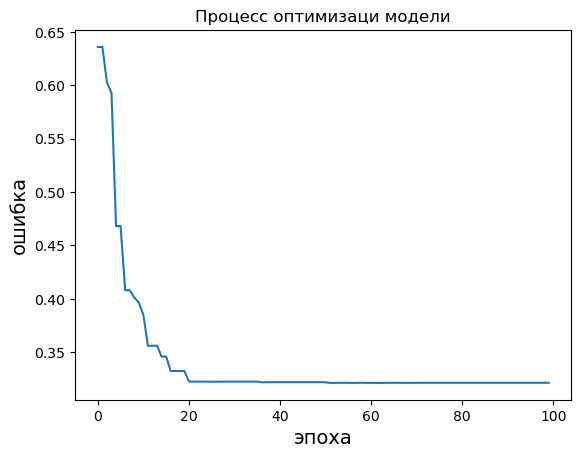

In [22]:
# Печать результатов
Appraiser.print_GA_NRS_model_elements_state(work_model)

print("Точность модели:", 
        Appraiser.evaluate(Appraiser.metrics(work_model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('')
Appraiser.print_metrics(work_model)

fig, ax = plt.subplots(1,1)
ax.plot(accs)

plt.title('Процесс оптимизаци модели')
plt.xlabel('эпоха', fontsize=14)
plt.ylabel('ошибка', fontsize=14)

plt.show()

# Примеры расчета

## Простая насосно-рукавная система

Расстояние до Н0 40 м
Простая НРС с одной РРЛ и одним стволом
Насос (Н0); напор: 40 м; производительность: 3.5468573823569858 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; расход: 3.5468573823569858 л/с; потеря напора: 3.2426667909999995 м

Ствол (С2): "Б"; проводимость: 0.5850213671311502; напор: 36.757333209, м; расход: 3.5468573823569858, л/с


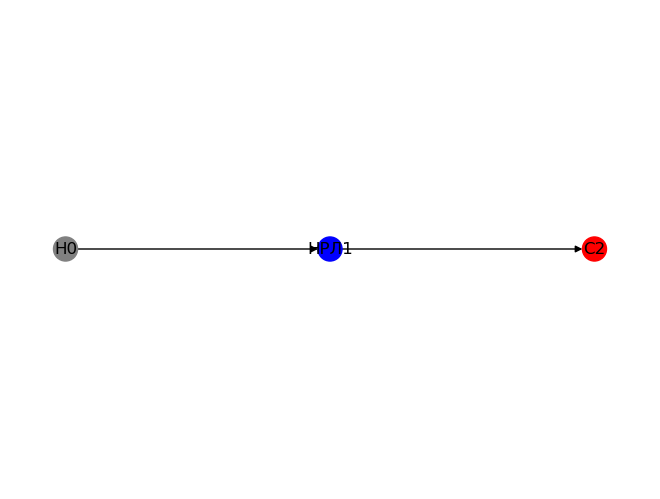

In [23]:
m = Presets.single_line()
m.calc(accuracy=0.05)
print_NRS_graph(m)
Appraiser.print_GA_NRS_model_elements_state(m)

In [24]:
# Цели оптимизации:
aims = {'150': 0, 'min_L': 500}   # , 'hoses':0, 'max_L': 2000
aims_not_more = {'51':20}   #, '66':20, '77':16} 
aims_not_less = {'Q':7}

# Запуск ГА:
work_model, accs, metrics = genetic_algorithm(model_preset=Presets.single_line,
                               aims=aims, aims_not_less=aims_not_less,
                               pop_size=400,
                               best_bots_size = 50,
                               mutation_count=5,
                               epochs=50,
                               target = 0.01
                               )

Размер популяции:  400 особей
0 >> 6.498998313250625 л/с :  0.3357858347678125
1 >> 6.218387382485076 л/с :  0.15582947267963737
2 >> 6.989522903996925 л/с :  0.01997913323098882
3 >> 7.3788270789039325 л/с :  0.0


In [25]:
# Печать результатов
Appraiser.print_GA_NRS_model_elements_state(work_model)

print("Точность модели:",
        Appraiser.evaluate(Appraiser.metrics(work_model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('')
Appraiser.print_metrics(work_model)

Простая НРС с одной РРЛ и одним стволом
Насос (Н0); напор: 60 м; производительность: 7.370286266832878 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 500 м; диаметр: 77 мм; сопротивление 0.015; расход: 7.370286266832878 л/с; потеря напора: 20.32058462011299 м

Ствол (С2): "А"; проводимость: 1.1700427342623003; напор: 39.67941537988701, м; расход: 7.370286266832878, л/с
Точность модели: 0.0

hoses	25
nozzles	1
distances	{'Н0': {'С2': 500}}
min_L	500
max_L	500
77	25
А	1
Н0:H_add	60
Q	7.370286266832878


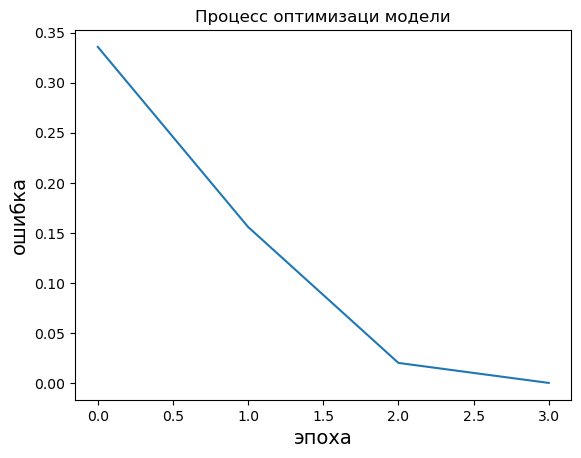

In [26]:
fig, ax = plt.subplots(1,1)
ax.plot(accs)

plt.title('Процесс оптимизаци модели')
plt.xlabel('эпоха', fontsize=14)
plt.ylabel('ошибка', fontsize=14)

plt.show()

Размер популяции:  400 особей
0 >> 12.098288291509357 л/с :  0.49754279271226604
1 >> 13.42480332482137 л/с :  0.4643799168794657
2 >> 6.411396192672709 л/с :  0.3597150951831823
3 >> 6.694210156486637 л/с :  0.3518755153186033
4 >> 6.781346208634478 л/с :  0.3504663447841381
5 >> 8.250081294725458 л/с :  0.29374796763186356
6 >> 8.240310193119877 л/с :  0.29399224517200306
7 >> 8.237733051475159 л/с :  0.29405667371312105
8 >> 8.516384034324492 л/с :  0.2870903991418877
9 >> 9.03940291088586 л/с :  0.2740149272278535
10 >> 9.02730673069132 л/с :  0.274317331732717
11 >> 9.024116035580551 л/с :  0.2743970991104862
12 >> 9.279308423945858 л/с :  0.26801728940135355
13 >> 9.519969523885688 л/с :  0.2620007619028578
14 >> 9.513401289653949 л/с :  0.2621649677586513
15 >> 9.511669450747252 л/с :  0.26220826373131867
16 >> 9.527912910313223 л/с :  0.2618021772421694
17 >> 9.527912656680387 л/с :  0.26180218358299034
18 >> 9.515496821717488 л/с :  0.2621125794570628
19 >> 9.512221881728125 л

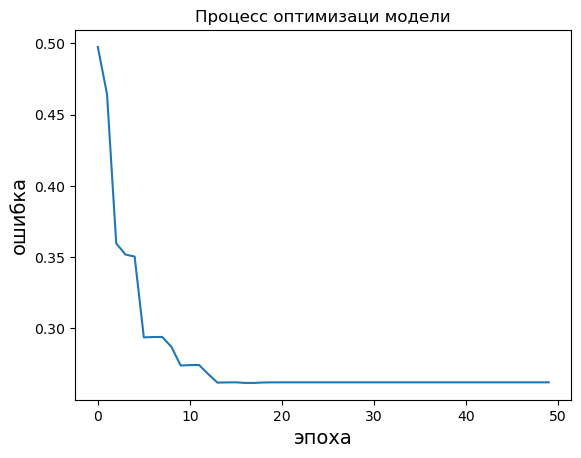

In [27]:
# Цели оптимизации:
aims = {'150': 0, 'min_L': 500, 'Q':20}   # , 'hoses':0, 'max_L': 2000
aims_not_more = {'51':20}   #, '66':20, '77':16} 
aims_not_less = {'Q':20}

# Запуск ГА:
work_model, accs, metrics = genetic_algorithm(model_preset=Presets.single_line,
                               aims=aims, #aims_not_less=aims_not_less,
                               pop_size=400,
                               best_bots_size = 50,
                               mutation_count=5,
                               epochs=50,
                               target = 0.01
                               )

# Печать результатов
Appraiser.print_GA_NRS_model_elements_state(work_model)

print("Точность модели:",
        Appraiser.evaluate(Appraiser.metrics(work_model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('')
Appraiser.print_metrics(work_model)

# График
fig, ax = plt.subplots(1,1)
ax.plot(accs)

plt.title('Процесс оптимизаци модели')
plt.xlabel('эпоха', fontsize=14)
plt.ylabel('ошибка', fontsize=14)

plt.show()

### Расчет для диапазона

In [28]:
Qs = []
lens = []
accs_list = []
# Цели оптимизации:
for q in [3,6,9,12,15,18,21,24,27,30,33]:
    aims = {'150': 0, 'min_L': 5000, 'Q':q}   # , 'hoses':0, 'max_L': 2000
    aims_not_more = {'51':20}   #, '66':20, '77':16} 
    aims_not_less = {'Q':20}

    # Запуск ГА:
    work_model, accs, metrics = genetic_algorithm(model_preset=Presets.single_line,
                                aims=aims, #aims_not_less=aims_not_less,
                                pop_size=400,
                                best_bots_size = 50,
                                mutation_count=5,
                                epochs=50,
                                target = 0.01
                                )
    Qs.append(work_model.summaryQ())
    lens.append(metrics[-1]['min_L'])
    accs_list.append(accs[-1])

Размер популяции:  400 особей
0 >> 2.97757833810404 л/с :  0.4797369436493266
1 >> 3.0187377491836878 л/с :  0.45510357353644826
2 >> 2.939085777139348 л/с :  0.43815237047677535
3 >> 2.9436311342085943 л/с :  0.43739481096523425
4 >> 2.89070154232298 л/с :  0.43021640961283675
5 >> 2.9700311791679863 л/с :  0.4129948034720023
6 >> 2.8333209808097934 л/с :  0.4097798365317011
7 >> 3.070080167706261 л/с :  0.4054134100541452
8 >> 3.0102037583646974 л/с :  0.37369486174089434
9 >> 2.9098708212246787 л/с :  0.34902152979588685
10 >> 2.900334576460873 л/с :  0.35061090392318783
11 >> 3.0699471620522174 л/с :  0.32939224200938017
12 >> 3.057994369579155 л/с :  0.3274824192869813
13 >> 3.0415074729101255 л/с :  0.3228235033580915
14 >> 3.0458785460382565 л/с :  0.31953125007199157
15 >> 3.0090843825270106 л/с :  0.3055094928177756
16 >> 3.004238342191279 л/с :  0.29470539379844735
17 >> 2.9648936817066622 л/с :  0.28385105304888963
18 >> 2.956911977237603 л/с :  0.28518133712706617
19 >> 2.8

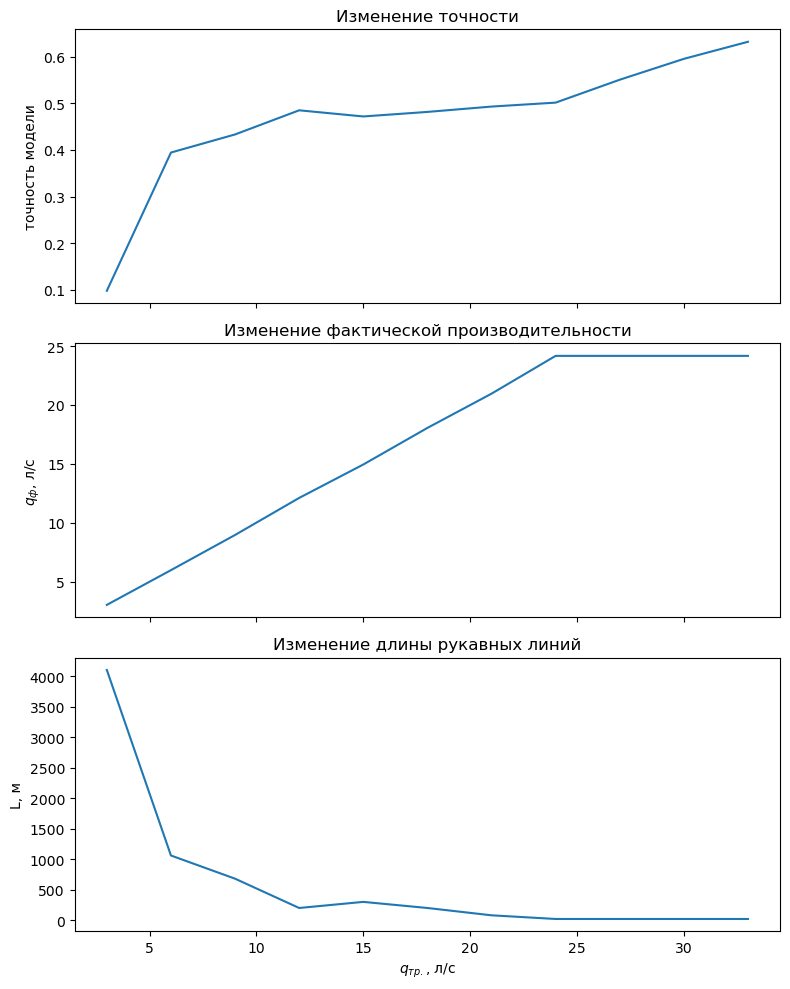

In [29]:
# График
x = [3,6,9,12,15,18,21,24,27,30,33]
fig, axs = plt.subplots(3,1, figsize=(8,10), sharex=True, tight_layout=True)
axs[0].plot(x, accs_list, label='1')
axs[0].set_title('Изменение точности')
axs[0].set_ylabel('точность модели')
axs[1].plot(x, Qs, label='2')
axs[1].set_title('Изменение фактической производительности')
axs[1].set_ylabel('$q_{ф}$, л/с')
axs[2].plot(x, lens, label='3')
axs[2].set_title('Изменение длины рукавных линий')
axs[2].set_ylabel('L, м')
axs[2].set_xlabel('$q_{тр.}$, л/с')

# plt.title('Процесс оптимизаци модели')
# plt.xlabel('эпоха', fontsize=14)
# plt.ylabel('ошибка', fontsize=14)

# plt.legend()
plt.show()

In [30]:
print(accs_list)
print(Qs)
print(lens)

[0.09801563717837941, 0.3943957613603716, 0.4331889342630147, 0.4849461891258128, 0.4717607485199289, 0.48149868724029904, 0.4929610378900257, 0.5014116392825946, 0.5505021530887577, 0.595251937779882, 0.6318653979817108]
[3.051067166202628, 5.995230750295015, 8.978599183114529, 12.120046371461864, 14.952451936331984, 18.055373238584693, 20.959636408618902, 24.16488373320708, 24.16488373320708, 24.16488373320708, 24.16488373320708]
[4100, 1060, 680, 200, 300, 200, 80, 20, 20, 20, 20]


In [31]:
Appraiser.print_GA_NRS_model_elements_state(work_model)

Простая НРС с одной РРЛ и одним стволом
Насос (Н0); напор: 100 м; производительность: 24.16488373320708 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 20 м; диаметр: 77 мм; сопротивление 0.015; расход: 24.16488373320708 л/с; потеря напора: 8.759124087591239 м

Ствол (С2): "Л"; проводимость: 2.5298221281347035; напор: 91.24087591240877, м; расход: 24.16488373320708, л/с


## Подбор параметров сложной насосно-рукавной системы

Расстояние до Н0 120 м
Сложная НРС с двумя разветвлениями и nozzles_count рабочих линий первого и второго порядка
Насос (Н0); напор: 40 м; производительность: 15.630755175477532 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; расход: 15.630755175477532 л/с; потеря напора: 7.348883524463349 м
Рукавная линия (НРЛ3), длина: 40 м; диаметр: 77 мм; сопротивление 0.015; расход: 9.224500706156626 л/с; потеря напора: 2.5605559622180154 м
Рукавная линия (НРЛ5), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; расход: 3.2031272346604536 л/с; потеря напора: 2.6729599191494313 м
Рукавная линия (НРЛ7), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; расход: 3.2031272346604536 л/с; потеря напора: 2.6729599191494313 м
Рукавная линия (НРЛ9), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; расход: 3.074833568718875 л/с; потеря напора: 2.46572055620994 м
Рукавная линия (НРЛ11), длина: 40 м; диаметр: 51 мм; сопротивление 0.13; расход: 3.074833568718875 л/с

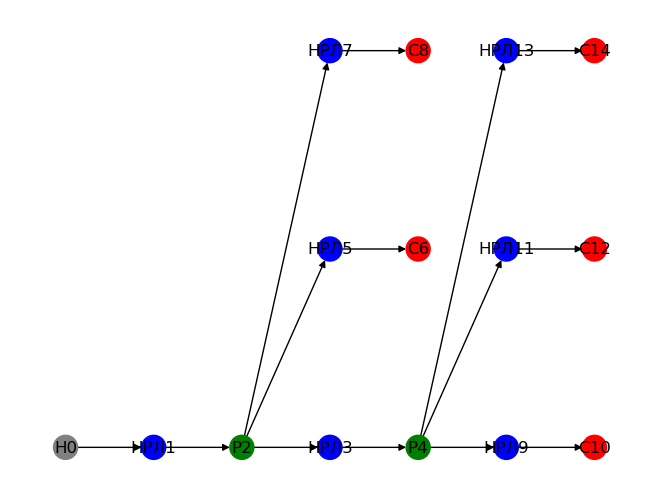

In [32]:
m = Presets.two_splitter(nozzles_count2=3)
m.calc(accuracy=0.05)
print_NRS_graph(m)
Appraiser.print_GA_NRS_model_elements_state(m)

Размер популяции:  400 особей
0 >> 19.378768636718313 л/с :  0.49242462726563385
1 >> 19.95810076049984 л/с :  0.48083798479000334
2 >> 19.767784400149395 л/с :  0.4546443119970121
3 >> 19.761450787835916 л/с :  0.4547709842432817
4 >> 19.34603242787461 л/с :  0.45307935144250777
5 >> 19.998433289666778 л/с :  0.45003133420666447
6 >> 19.990862343215113 л/с :  0.4501827531356978
7 >> 19.98611998190087 л/с :  0.4502776003619826
8 >> 19.983143690974124 л/с :  0.4503371261805175
9 >> 19.98127433794174 л/с :  0.4503745132411652
10 >> 19.561583159793305 л/с :  0.4087683368041339
11 >> 19.55485813001906 л/с :  0.40890283739961875
12 >> 19.55015218113457 л/с :  0.4089969563773086
13 >> 19.546859058176132 л/с :  0.4090628188364773
14 >> 19.54455464044041 л/с :  0.40910890719119186
15 >> 19.634671571838307 л/с :  0.40730656856323383
16 >> 19.641940385781254 л/с :  0.3971611922843749
17 >> 19.650154639989257 л/с :  0.3969969072002149
18 >> 19.653554724872308 л/с :  0.3969289055025539
19 >> 19.07

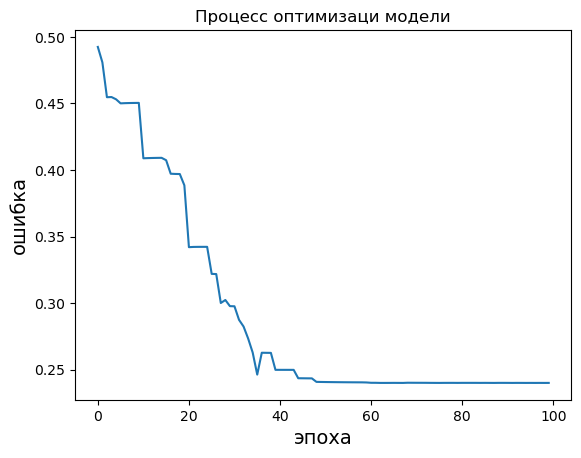

In [33]:
# Цели оптимизации:
aims = {'150': 0, 'Н0:H_add':100, 'hoses':0, 'Q':20}   # , 'hoses':0, 'max_L': 2000', 'min_L': 500, 
# aims_not_more = {'51':20}   #, '66':20, '77':16} 
aims_not_less = {'Q':20, 'min_L': 400}

# Запуск ГА:
work_model, accs, metrics = genetic_algorithm(model_preset=Presets.two_splitter,
                               aims=aims, aims_not_less=aims_not_less,
                               pop_size=400,
                               best_bots_size = 50,
                               mutation_count=5,
                               epochs=100,
                               target = 0.01
                               )

# Печать результатов
Appraiser.print_GA_NRS_model_elements_state(work_model)

print("Точность модели:",
        Appraiser.evaluate(Appraiser.metrics(work_model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('')
Appraiser.print_metrics(work_model)

# График
fig, ax = plt.subplots(1,1)
ax.plot(accs)

plt.title('Процесс оптимизаци модели')
plt.xlabel('эпоха', fontsize=14)
plt.ylabel('ошибка', fontsize=14)

plt.show()

Размер популяции:  400 особей
0 >> 19.99048536470707 л/с :  0.5001902927058586
1 >> 19.630353218183014 л/с :  0.4873929356363397
2 >> 19.963742164144193 л/с :  0.45072515671711616
3 >> 19.97143094061074 л/с :  0.4505713811877852
4 >> 19.973393556969526 л/с :  0.4505321288606095
5 >> 19.983108797569486 л/с :  0.4403378240486103
6 >> 19.977695235151764 л/с :  0.44044609529696477
7 >> 19.260432492761176 л/с :  0.42979135014477654
8 >> 18.86307474914908 л/с :  0.39273850501701835
9 >> 18.644044375249607 л/с :  0.3571191124950079
10 >> 18.654302765313854 л/с :  0.35691394469372295
11 >> 19.692377112442852 л/с :  0.33615245775114294
12 >> 19.887669759593788 л/с :  0.3222466048081243
13 >> 19.804804326665142 л/с :  0.2989039134666972
14 >> 19.7972472815951 л/с :  0.299055054368098
15 >> 19.79691657316188 л/с :  0.2990616685367624
16 >> 19.912450117472176 л/с :  0.29175099765055645
17 >> 19.92335738510978 л/с :  0.29153285229780435
18 >> 19.89259878751063 л/с :  0.2871480242497874
19 >> 19.901

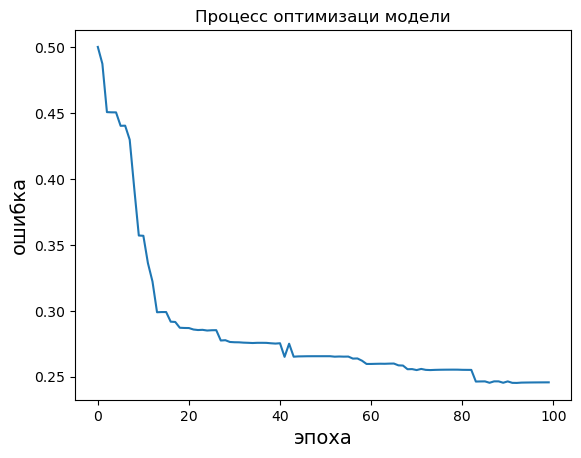

In [34]:
# Цели оптимизации:
aims = {'Н0:H_add':100, 'hoses':0, 'Q':20}   # , 'hoses':0, 'max_L': 2000', 'min_L': 500, '150': 0, 
aims_not_more = {'150':25}   #, '66':20, '77':16} 
aims_not_less = {'Q':20, 'min_L': 800}

# Запуск ГА:
work_model, accs, metrics = genetic_algorithm(model_preset=Presets.two_splitter,
                               aims=aims, aims_not_less=aims_not_less,
                               pop_size=400,
                               best_bots_size = 50,
                               mutation_count=5,
                               epochs=100,
                               target = 0.01
                               )

# Печать результатов
Appraiser.print_GA_NRS_model_elements_state(work_model)

print("Точность модели:",
        Appraiser.evaluate(Appraiser.metrics(work_model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('')
Appraiser.print_metrics(work_model)

# График
fig, ax = plt.subplots(1,1)
ax.plot(accs)

plt.title('Процесс оптимизаци модели')
plt.xlabel('эпоха', fontsize=14)
plt.ylabel('ошибка', fontsize=14)

plt.show()

## НРС с перекачкой и несколькими ветвями

### Схема №1

Расстояние до ПНС 60 м
Полный граф изобразить не возможно, будет отображен упрощенный


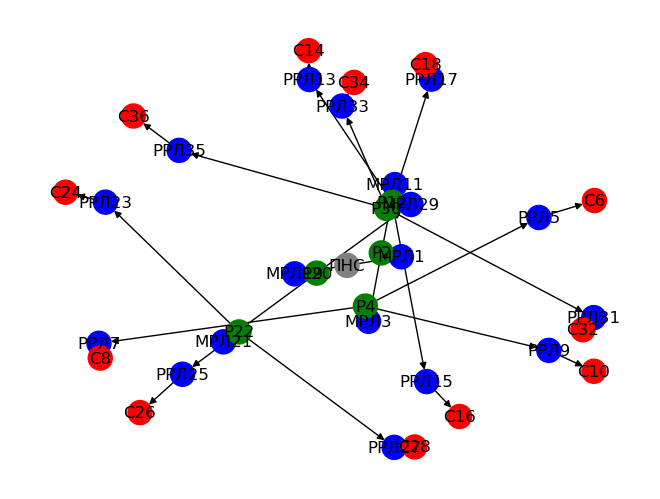

In [84]:
# Функция для построения произвольной модели
def build_model_1():
    # Структура модели
    pA = NRS_Revision.calc_p(7.4, 40)

    pumpPNS = GA_Element_Pump('ПНС', e_type=0, H_add=60, Q_max=110)
    hoseM_A1 = GA_Element_MHose('', e_type=1, d='150', s=NRS_Data.ss['150'])
    hoseM_A2 = GA_Element_MHose('', e_type=1, d='150', s=NRS_Data.ss['150'])
    splitter_A1 = GA_Element_Splitter('', e_type=1)
    splitter_A2 = GA_Element_Splitter('', e_type=1)
    hoseM_B1 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseM_B2 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseM_B3 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseM_B4 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    splitter_B1 = GA_Element_Splitter('', e_type=1)
    splitter_B2 = GA_Element_Splitter('', e_type=1)
    splitter_B3 = GA_Element_Splitter('', e_type=1)
    splitter_B4 = GA_Element_Splitter('', e_type=1)
    hoseW_C1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C3 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C4 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C5 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C6 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C7 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C8 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C9 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C10 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C11 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C12 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])

    nozzle_C1 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C2 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C3 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C4 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C5 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C6 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C7 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C8 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C9 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C10 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C11 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)
    nozzle_C12 = GA_Element_Nozzle('', e_type=2, n_type='А', p=pA, q_out=q_out_nozzle)

    pumpPNS.append(hoseM_A1).append(splitter_A1)
    pumpPNS.append(hoseM_A2).append(splitter_A2)

    splitter_A1.append(hoseM_B1).append(splitter_B1)
    splitter_A1.append(hoseM_B2).append(splitter_B2)
    splitter_A2.append(hoseM_B3).append(splitter_B3)
    splitter_A2.append(hoseM_B4).append(splitter_B4)

    splitter_B1.append(hoseW_C1).append(nozzle_C1)
    splitter_B1.append(hoseW_C2).append(nozzle_C2)
    splitter_B1.append(hoseW_C3).append(nozzle_C3)

    splitter_B2.append(hoseW_C4).append(nozzle_C4)
    splitter_B2.append(hoseW_C5).append(nozzle_C5)
    splitter_B2.append(hoseW_C6).append(nozzle_C6)    

    splitter_B3.append(hoseW_C7).append(nozzle_C7)
    splitter_B3.append(hoseW_C8).append(nozzle_C8)
    splitter_B3.append(hoseW_C9).append(nozzle_C9) 

    splitter_B4.append(hoseW_C10).append(nozzle_C10)
    splitter_B4.append(hoseW_C11).append(nozzle_C11)
    splitter_B4.append(hoseW_C12).append(nozzle_C12) 

    model = GA_model('Модель 1')
    # model.addElements([pump1,hoseM1,hoseM2,pump2,hoseM3,splitter,hoseW1,hoseW2,hoseW3,nozzle1,nozzle2,nozzle3])
    model.build(pumpPNS)
    return model.check_pumps().interpretate()

model = build_model_1()
print_NRS_graph(model)

In [65]:
model.calc(accuracy=0.05)

Appraiser.print_GA_NRS_model_elements_state(model)

Модель 1
Насос (ПНС); напор: 60 м; производительность: 98.14183530588791 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 20 м; диаметр: 150 мм; сопротивление 0.00046; расход: 49.07091765294397 л/с; потеря напора: 1.1077028760250671 м
Рукавная линия (НРЛ3), длина: 20 м; диаметр: 77 мм; сопротивление 0.015; расход: 24.53545882647198 л/с; потеря напора: 9.030186489334788 м
Рукавная линия (НРЛ5), длина: 20 м; диаметр: 77 мм; сопротивление 0.015; расход: 8.17848627549066 л/с; потеря напора: 1.003354054370532 м
Рукавная линия (НРЛ7), длина: 20 м; диаметр: 77 мм; сопротивление 0.015; расход: 8.17848627549066 л/с; потеря напора: 1.003354054370532 м
Рукавная линия (НРЛ9), длина: 20 м; диаметр: 77 мм; сопротивление 0.015; расход: 8.17848627549066 л/с; потеря напора: 1.003354054370532 м
Рукавная линия (НРЛ11), длина: 20 м; диаметр: 77 мм; сопротивление 0.015; расход: 24.53545882647198 л/с; потеря напора: 9.030186489334788 м
Рукавная линия (НРЛ13), длина: 20 м; диаметр: 77 мм; сопротивление 0

Размер популяции:  200 особей
0 >> 99.40087911214331 л/с :  0.6586637362928556
1 >> 99.60583886902383 л/с :  0.6579805371032539
2 >> 99.90673640699772 л/с :  0.6569775453100076
3 >> 99.90614437380393 л/с :  0.6569795187539869
4 >> 91.73659436030876 л/с :  0.6542113521323042
5 >> 92.38947586006398 л/с :  0.6520350804664533
6 >> 92.39995667128335 л/с :  0.6520001444290555
7 >> 97.88800173517019 л/с :  0.633706660882766
8 >> 99.61499512705 л/с :  0.6279500162431666
9 >> 99.67399539233406 л/с :  0.6277533486922198
10 >> 99.87165301064356 л/с :  0.6270944899645214
11 >> 99.8620902116991 л/с :  0.627126365961003
12 >> 99.85797298174937 л/с :  0.6271400900608355
13 >> 99.99805927132964 л/с :  0.6266731357622345
14 >> 99.85543703804028 л/с :  0.6271485432065323
15 >> 99.98256765206959 л/с :  0.6267247744931014
16 >> 99.97254510116994 л/с :  0.6267581829961002
17 >> 99.97903712081151 л/с :  0.6267365429306283
18 >> 99.9836018278583 л/с :  0.6267213272404724
19 >> 93.34060188322901 л/с :  0.6255

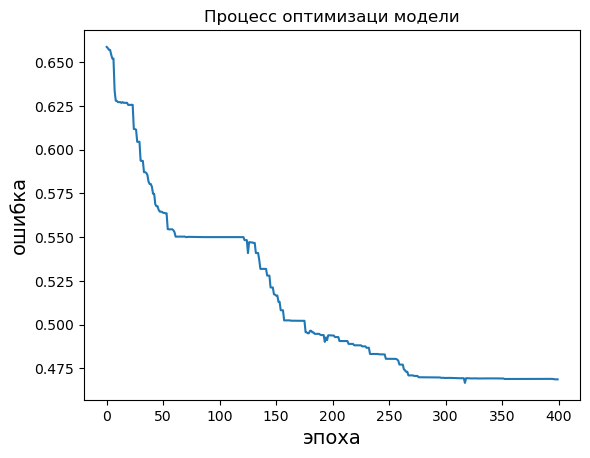

In [68]:
# Цели оптимизации:
aims = {'hoses':0}   # , 'hoses':0, 'max_L': 2000', 'min_L': 500, '150': 0,  'Н0:H_add':100, 
aims_not_more = {'150':67}   #, '66':20, '77':16} 
aims_not_less = {'Q':100, 'min_L': 2000}

# Запуск ГА:
work_model, accs, metrics = genetic_algorithm(model_preset=build_model_1,
                               aims=aims, aims_not_less=aims_not_less,
                               pop_size=200,
                               best_bots_size = 25,
                               mutation_count=5,
                               epochs=400,
                               target = 0.01,
                               accuracy=0.5
                               )

# Печать результатов
Appraiser.print_GA_NRS_model_elements_state(work_model)

print("Точность модели:",
        Appraiser.evaluate(Appraiser.metrics(work_model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('')
Appraiser.print_metrics(work_model)

# График
fig, ax = plt.subplots(1,1)
ax.plot(accs)

plt.title('Процесс оптимизаци модели')
plt.xlabel('эпоха', fontsize=14)
plt.ylabel('ошибка', fontsize=14)

plt.show()

### Схема №2

Расстояние до ПНС 80 м
Модель 1
Насос (ПНС); напор: 60 м; производительность: 61.868948839906885 л/с; напор макс.: 100
Насос (Н4); напор: 40 м; производительность: 15.467237209976718 л/с; напор макс.: 100
Насос (Н14); напор: 40 м; производительность: 15.467237209976718 л/с; напор макс.: 100
Насос (Н26); напор: 40 м; производительность: 15.467237209976718 л/с; напор макс.: 100
Насос (Н36); напор: 40 м; производительность: 15.467237209976718 л/с; напор макс.: 100

Рукавная линия (НРЛ1), длина: 20 м; диаметр: 150 мм; сопротивление 0.00046; расход: 30.93447441995344 л/с; потеря напора: 0.4405099765667582 м
Рукавная линия (НРЛ3), длина: 20 м; диаметр: 77 мм; сопротивление 0.015; расход: 15.467237209976718 л/с; потеря напора: 3.591113939402921 м
Рукавная линия (НРЛ5), длина: 20 м; диаметр: 77 мм; сопротивление 0.015; расход: 15.467237209976718 л/с; потеря напора: 3.591113939402921 м
Рукавная линия (НРЛ7), длина: 20 м; диаметр: 77 мм; сопротивление 0.015; расход: 5.155745736658906 л/с; потеря

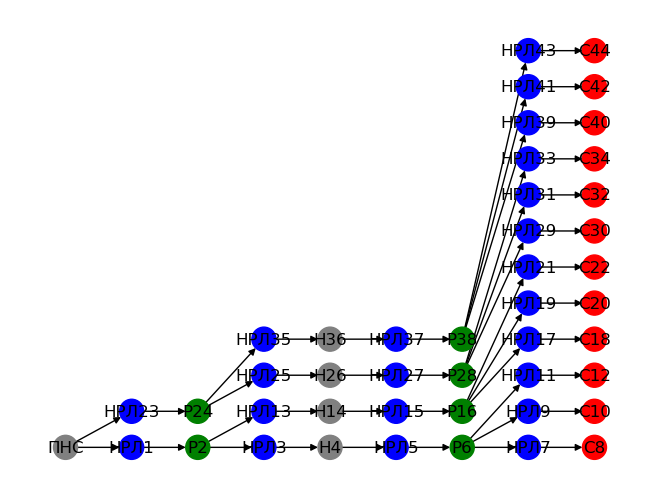

In [70]:
# Функция для построения произвольной модели
def build_model_2():
    # Структура модели
    pA = NRS_Revision.calc_p(7.4, 40)
    pB = NRS_Revision.calc_p(3.4, 40)

    pumpPNS = GA_Element_Pump('ПНС', e_type=0, H_add=60, Q_max=110)
    hoseM_A1 = GA_Element_MHose('', e_type=1, d='150', s=NRS_Data.ss['150'])
    hoseM_A2 = GA_Element_MHose('', e_type=1, d='150', s=NRS_Data.ss['150'])
    splitter_A1 = GA_Element_Splitter('', e_type=1)
    splitter_A2 = GA_Element_Splitter('', e_type=1)

    pump_A1 = GA_Element_Pump('', e_type=1, H_add=40, Q_max=40)
    pump_A2 = GA_Element_Pump('', e_type=1, H_add=40, Q_max=40)
    pump_A3 = GA_Element_Pump('', e_type=1, H_add=40, Q_max=40)
    pump_A4 = GA_Element_Pump('', e_type=1, H_add=40, Q_max=40)

    hoseM_AB1 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseM_AB2 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseM_AB3 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseM_AB4 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])    

    hoseM_B1 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseM_B2 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseM_B3 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseM_B4 = GA_Element_MHose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    splitter_B1 = GA_Element_Splitter('', e_type=1)
    splitter_B2 = GA_Element_Splitter('', e_type=1)
    splitter_B3 = GA_Element_Splitter('', e_type=1)
    splitter_B4 = GA_Element_Splitter('', e_type=1)
    hoseW_C1 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C2 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C3 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C4 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C5 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C6 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C7 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C8 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C9 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C10 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C11 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])
    hoseW_C12 = GA_Element_Hose('', e_type=1, d='77', s=NRS_Data.ss['77'])

    nozzle_C1 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C2 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C3 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C4 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C5 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C6 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C7 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C8 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C9 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C10 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C11 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)
    nozzle_C12 = GA_Element_Nozzle('', e_type=2, n_type='Б', p=pB, q_out=q_out_nozzle)

    pumpPNS.append(hoseM_A1).append(splitter_A1)
    pumpPNS.append(hoseM_A2).append(splitter_A2)

    splitter_A1.append(hoseM_B1).append(pump_A1).append(hoseM_AB1).append(splitter_B1)
    splitter_A1.append(hoseM_B2).append(pump_A2).append(hoseM_AB2).append(splitter_B2)
    splitter_A2.append(hoseM_B3).append(pump_A3).append(hoseM_AB3).append(splitter_B3)
    splitter_A2.append(hoseM_B4).append(pump_A4).append(hoseM_AB4).append(splitter_B4)

    splitter_B1.append(hoseW_C1).append(nozzle_C1)
    splitter_B1.append(hoseW_C2).append(nozzle_C2)
    splitter_B1.append(hoseW_C3).append(nozzle_C3)

    splitter_B2.append(hoseW_C4).append(nozzle_C4)
    splitter_B2.append(hoseW_C5).append(nozzle_C5)
    splitter_B2.append(hoseW_C6).append(nozzle_C6)    

    splitter_B3.append(hoseW_C7).append(nozzle_C7)
    splitter_B3.append(hoseW_C8).append(nozzle_C8)
    splitter_B3.append(hoseW_C9).append(nozzle_C9) 

    splitter_B4.append(hoseW_C10).append(nozzle_C10)
    splitter_B4.append(hoseW_C11).append(nozzle_C11)
    splitter_B4.append(hoseW_C12).append(nozzle_C12) 

    model = GA_model('Модель 1')
    # model.addElements([pump1,hoseM1,hoseM2,pump2,hoseM3,splitter,hoseW1,hoseW2,hoseW3,nozzle1,nozzle2,nozzle3])
    model.build(pumpPNS)
    return model.check_pumps().interpretate()

model = build_model_2()
print_NRS_graph(model)

model.calc(accuracy=0.05)
Appraiser.print_GA_NRS_model_elements_state(model)

Размер популяции:  400 особей
0 >> 92.91448394404063 л/с :  0.6769517201865313
1 >> 99.46270047002135 л/с :  0.6551243317665955
2 >> 99.70840579218671 л/с :  0.6543053140260443
3 >> 99.97616086925618 л/с :  0.6534127971024793
4 >> 99.9999415237128 л/с :  0.6533335282542906
5 >> 96.85906130598738 л/с :  0.653803128980042
6 >> 99.85629309973181 л/с :  0.6438123563342273
7 >> 99.9780956545277 л/с :  0.6434063478182409
8 >> 99.88262450492509 л/с :  0.643724584983583
9 >> 99.80397285595836 л/с :  0.6439867571468054
10 >> 99.79473971134612 л/с :  0.6440175342955129
11 >> 99.82807965522629 л/с :  0.6439064011492457
12 >> 99.97226552572305 л/с :  0.6434257815809231
13 >> 99.95885889774375 л/с :  0.6434704703408541
14 >> 99.98024522900984 л/с :  0.6433991825699672
15 >> 99.9855911823699 л/с :  0.6433813627254337
16 >> 96.9767770227613 л/с :  0.6400774099241291
17 >> 99.91380103294966 л/с :  0.6302873298901678
18 >> 99.85738698029206 л/с :  0.6304753767323598
19 >> 99.89692784990616 л/с :  0.630

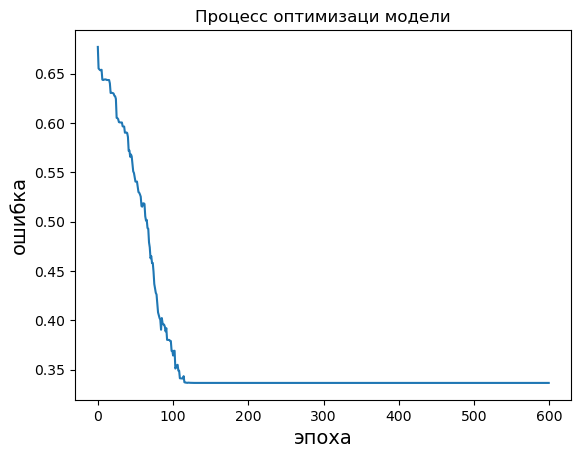

In [73]:
# Цели оптимизации:
aims = {'hoses':0}   # , 'hoses':0, 'max_L': 2000', 'min_L': 500, '150': 0,  'Н0:H_add':100, 
aims_not_more = {'150':67, 'max_L': 2200}   #, '66':20, '77':16} 
aims_not_less = {'Q':100, 'min_L': 2000}

# Запуск ГА:
work_model, accs, metrics = genetic_algorithm(model_preset=build_model_2,
                               aims=aims, aims_not_less=aims_not_less,
                               pop_size=400,
                               best_bots_size = 25,
                               mutation_count=5,
                               epochs=600,
                               target = 0.01,
                               accuracy=0.5
                               )

# Печать результатов
Appraiser.print_GA_NRS_model_elements_state(work_model)

print("Точность модели:",
        Appraiser.evaluate(Appraiser.metrics(work_model), aims=aims, aims_not_more=aims_not_more, aims_not_less=aims_not_less))
print('')
Appraiser.print_metrics(work_model)

# График
fig, ax = plt.subplots(1,1)
ax.plot(accs)

plt.title('Процесс оптимизаци модели')
plt.xlabel('эпоха', fontsize=14)
plt.ylabel('ошибка', fontsize=14)

plt.show()

# Печать графа с иконками

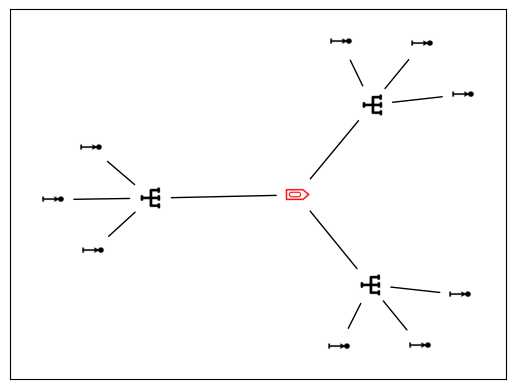

In [36]:


# Image URLs for graph nodes
icons = {
    "router": "icons/AC.png",
    "switch": "icons/Splitter.png",
    "PC": "icons/Nozzle.png",
}

# Load images
images = {k: PIL.Image.open(fname) for k, fname in icons.items()}

# Generate the computer network graph
G = nx.Graph()

G.add_node("router", image=images["router"])
for i in range(1, 4):
    G.add_node(f"switch_{i}", image=images["switch"])
    for j in range(1, 4):
        G.add_node("PC_" + str(i) + "_" + str(j), image=images["PC"])

G.add_edge("router", "switch_1")
G.add_edge("router", "switch_2")
G.add_edge("router", "switch_3")
for u in range(1, 4):
    for v in range(1, 4):
        G.add_edge("switch_" + str(u), "PC_" + str(u) + "_" + str(v))

# Get a reproducible layout and create figure
pos = nx.spring_layout(G, seed=1734289230)
fig, ax = plt.subplots()

# Note: the min_source/target_margin kwargs only work with FancyArrowPatch objects.
# Force the use of FancyArrowPatch for edge drawing by setting `arrows=True`,
# but suppress arrowheads with `arrowstyle="-"`
nx.draw_networkx_edges(
    G,
    pos=pos,
    ax=ax,
    arrows=True,
    arrowstyle="-",
    min_source_margin=15,
    min_target_margin=15,
)

# Transform from data coordinates (scaled between xlim and ylim) to display coordinates
tr_figure = ax.transData.transform
# Transform from display to figure coordinates
tr_axes = fig.transFigure.inverted().transform

# Select the size of the image (relative to the X axis)
icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.025
icon_center = icon_size / 2.0

# Add the respective image to each node
for n in G.nodes:
    xf, yf = tr_figure(pos[n])
    xa, ya = tr_axes((xf, yf))
    # get overlapped axes and plot icon
    a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
    a.imshow(G.nodes[n]["image"])
    a.axis("off")
plt.show()

Расстояние до Н0 80 м
Полный граф изобразить не возможно, будет отображен упрощенный


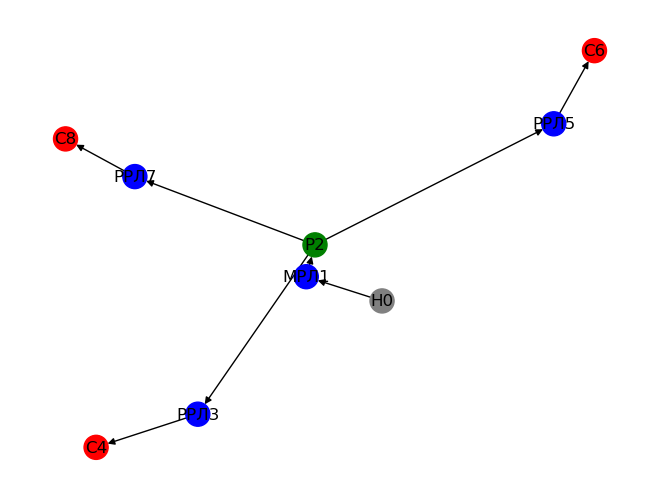

In [79]:
model = Presets.single_splitter()

G = Appraiser.get_G(model)

print_NRS_graph(model)

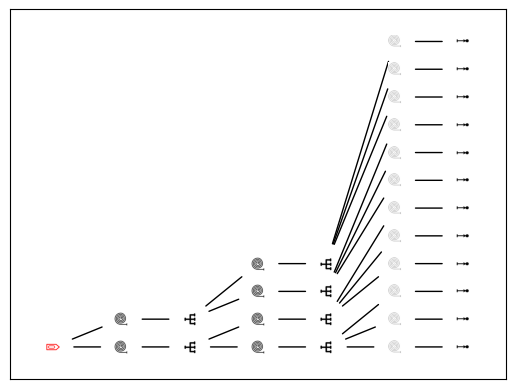

In [90]:
def plot_nrs_with_icons(model, margin=15, size_reduce=0.004):
    '''
    Печать графа НРС с иконками
    '''
    icons = {
        "GA_Element_Pump": "icons/AC.png",
        "GA_Element_Splitter": "icons/Splitter.png",
        "GA_Element_Joiner": "icons/Joiner.png",
        "GA_Element_Hose": "icons/WHose.png",
        "GA_Element_MHose": "icons/MHose.png",
        "GA_Element_Nozzle": "icons/Nozzle.png",
    }
    images = {k: PIL.Image.open(fname) for k, fname in icons.items()}

    # Получаем граф
    G = Appraiser.get_G(model)

    # Печать графа НРС с позициями
    pos={}
    pos_list=[]
    level=0
    for eo in model.elmnts_in:
        v = eo.name
        spl = dict(nx.single_source_shortest_path_length(G, v))
        for nd, p in spl.items():
            if not nd in pos.keys():
                level_rize=level
                cpos = (p,level_rize)
                while cpos in pos_list:
                    level_rize+=1
                    cpos = (p,level_rize)
                pos[nd]=cpos
                pos_list.append(cpos)
        level+=1


    fig, ax = plt.subplots()

    nx.draw_networkx_edges(
        G,
        pos=pos,
        ax=ax,
        arrows=True,
        arrowstyle="-",
        min_source_margin=margin,
        min_target_margin=margin,
    )


    # Трансформация к координатам полотна
    tr_figure = ax.transData.transform
    tr_axes = fig.transFigure.inverted().transform

    # Определяем размер иконок
    icon_size = (ax.get_xlim()[1] - ax.get_xlim()[0]) * size_reduce
    icon_center = icon_size / 2.0

    # Добавляем иконки
    for n, d in G.nodes(data=True):
        elmnt = model.getElement(n)

        xf, yf = tr_figure(pos[n])
        xa, ya = tr_axes((xf, yf))
        a = plt.axes([xa - icon_center, ya - icon_center, icon_size, icon_size])
        a.imshow(images[elmnt.id])
        a.axis("off")

    plt.show()


# model = Presets.single_splitter()
# plot_with_icons(Presets.two_splitter())
plot_nrs_with_icons(build_model_1())

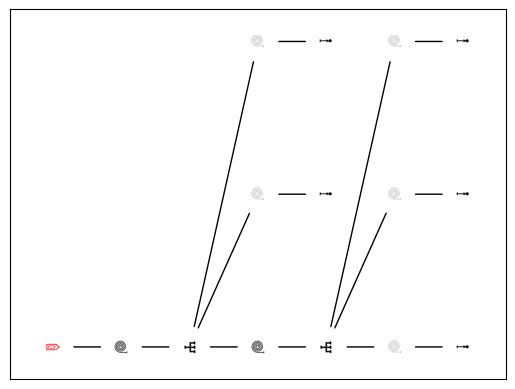

In [91]:
plot_nrs_with_icons(Presets.two_splitter())

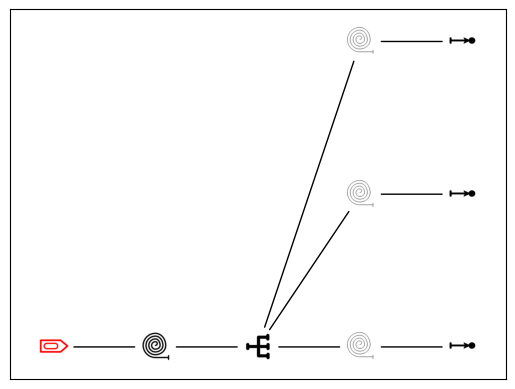

In [96]:
plot_nrs_with_icons(Presets.single_splitter(), size_reduce=0.0125)